In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from source import *  # hist_approx, json_update, normalization, etc.
import scienceplots

plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# ----- Каналы и служебные пути -----
CHANNELS = ['lep', 'pipi', 'rhorho', 'pirho', 'pilep', 'rholep']

def load_channel_objects(ch: str):
    """PDF-ы канала и эталонное N_bg (для масштаба/тестов)."""
    f_bg = hist_approx().load_hist(f"shapes/bg_{ch}.json").get_pdf
    f_sig = hist_approx().load_hist(f"shapes/sig_{ch}.json").get_pdf
    with open(f"quantity/N_{ch}.json", "r", encoding="utf-8") as f:
        ds = json.load(f)
    N_bg = float(ds["N_bg"])
    return f_sig, f_bg, N_bg

def load_channel_eps(ch: str, default: float = 1.0) -> float:
    """
    Возвращает ε_ch = selection_eff * BDT_eff из results/data_{ch}.json.
    Если какого-то ключа нет — подставляет 1.0 (нейтрально).
    """
    with open(f"results/data_{ch}.json", "r", encoding="utf-8") as f:
        ds = json.load(f)

    sel = float(ds.get("selection_eff", default))
    # поддержим оба варианта регистра на всякий случай
    bdt = ds.get("BDT_eff", ds.get("bdt_eff", 1.0))
    bdt = float(bdt)

    # мягкая защита от экзотики: зажмём в [0, 1]
    sel = max(0.0, min(1.0, sel))
    bdt = max(0.0, min(1.0, bdt))

    return sel * bdt
# -------------------- Генерация той-данных --------------------
def gen_toy_nd(pdf_func, bounds, size=10000, grid_points=50, rng=None):
    """nD accept-reject из заданной pdf_func; bounds = [(a1,b1), (a2,b2), ...]."""
    if rng is None:
        rng = np.random.default_rng()
    grids = [np.linspace(a, b, grid_points) for a, b in bounds]
    meshes = np.meshgrid(*grids, indexing='ij')
    Z = pdf_func(meshes)
    ymax = float(np.max(Z)) if np.isfinite(np.max(Z)) and np.max(Z) > 0 else 1.0
    samples = []
    while len(samples) < size:
        x_trial = [rng.uniform(a, b) for a, b in bounds]
        y_trial = rng.uniform(0.0, ymax)
        x_arr = [np.array([xi]) for xi in x_trial]
        if y_trial <= float(pdf_func(x_arr)):
            samples.append(x_trial)
    return np.array(samples)

In [2]:
BS0 = 5.366691
wbin_x, a_x, b_x = 0.10, 0.0, 1.2
wbin_y, a_y, b_y = 0.01, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x) + 2)
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y) + 2)
x_centers = 0.5 * (bins_x[:-1] + bins_x[1:])
y_centers = 0.5 * (bins_y[:-1] + bins_y[1:])

In [3]:
def combined_max_lik_ext_eps(channel_data, channel_pdfs, eps, args0, bounds=None, err_need=False):
    """
    channel_data: dict[ch] -> np.ndarray (2, n_c)
    channel_pdfs: dict[ch] -> (f_sig_ch, f_bg_ch)
    eps: dict[ch] -> epsilon_c (selection efficiency)
    Параметры: N_tt (общий), и N_bg_fit_{ch} (поканальные).
    """
    from iminuit import Minuit
    from scipy.stats import poisson
    from numpy import log

    pnames = list(args0.keys())

    def nll(*vals):
        pars = {k: v for k, v in zip(pnames, vals)}
        B_tt = pars["B_tt"]
        ll = 0.0

        for ch, X in channel_data.items():
            fsig, fbg = channel_pdfs[ch]
            e = eps[ch] 
            Nbg_fit_ch = pars[f"N_bg_fit_{ch}"]

            Nsig_c = B_tt * (e * 7.9 * 10e6 * 2)
            Nbg_c  = Nbg_fit_ch

            # смесь (eps сокращается внутри дроби)
            mix = (Nsig_c * fsig(X) + Nbg_c * fbg(X)) / (Nsig_c + Nbg_c)

            ll += np.sum(log(mix))
            nobs = X.shape[1]
            mu   = Nsig_c + Nbg_c  # = e*(Ntt + Nbg_fit_ch)
            ll += poisson.logpmf(nobs, mu)

        return -2.0 * ll

    m = Minuit(nll, *[args0[k] for k in pnames], name=pnames)
    if bounds:
        for k, bnd in bounds.items():
            m.limits[k] = bnd
    m.migrad()

    rez  = m.values.to_dict()
    errs = m.errors.to_dict() if err_need else None
    return rez, errs


C:\Users\marc\AppData\Local\Temp\ipykernel_20540\1889248038.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if y_trial <= float(pdf_func(x_arr)):
C:\Users\marc\AppData\Local\Temp\ipykernel_20540\1883445937.py:30: RuntimeWarning: invalid value encountered in log
  ll += np.sum(log(mix))


0.00013335085330701268
6048.24


C:\Users\marc\AppData\Local\Temp\ipykernel_20540\3805477464.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fit_proj_x_sig = np.trapz(src_sig, y_centers, axis=1) * wbin_x
C:\Users\marc\AppData\Local\Temp\ipykernel_20540\3805477464.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fit_proj_x_bg  = np.trapz(src_bg,  y_centers, axis=1) * wbin_x
C:\Users\marc\AppData\Local\Temp\ipykernel_20540\3805477464.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fit_proj_y_sig = np.trapz(src_sig, x_centers, axis=0) * wbin_y
C:\Users\marc\AppData\Local\Temp\ipykernel_20540\3805477464.py:85: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integ

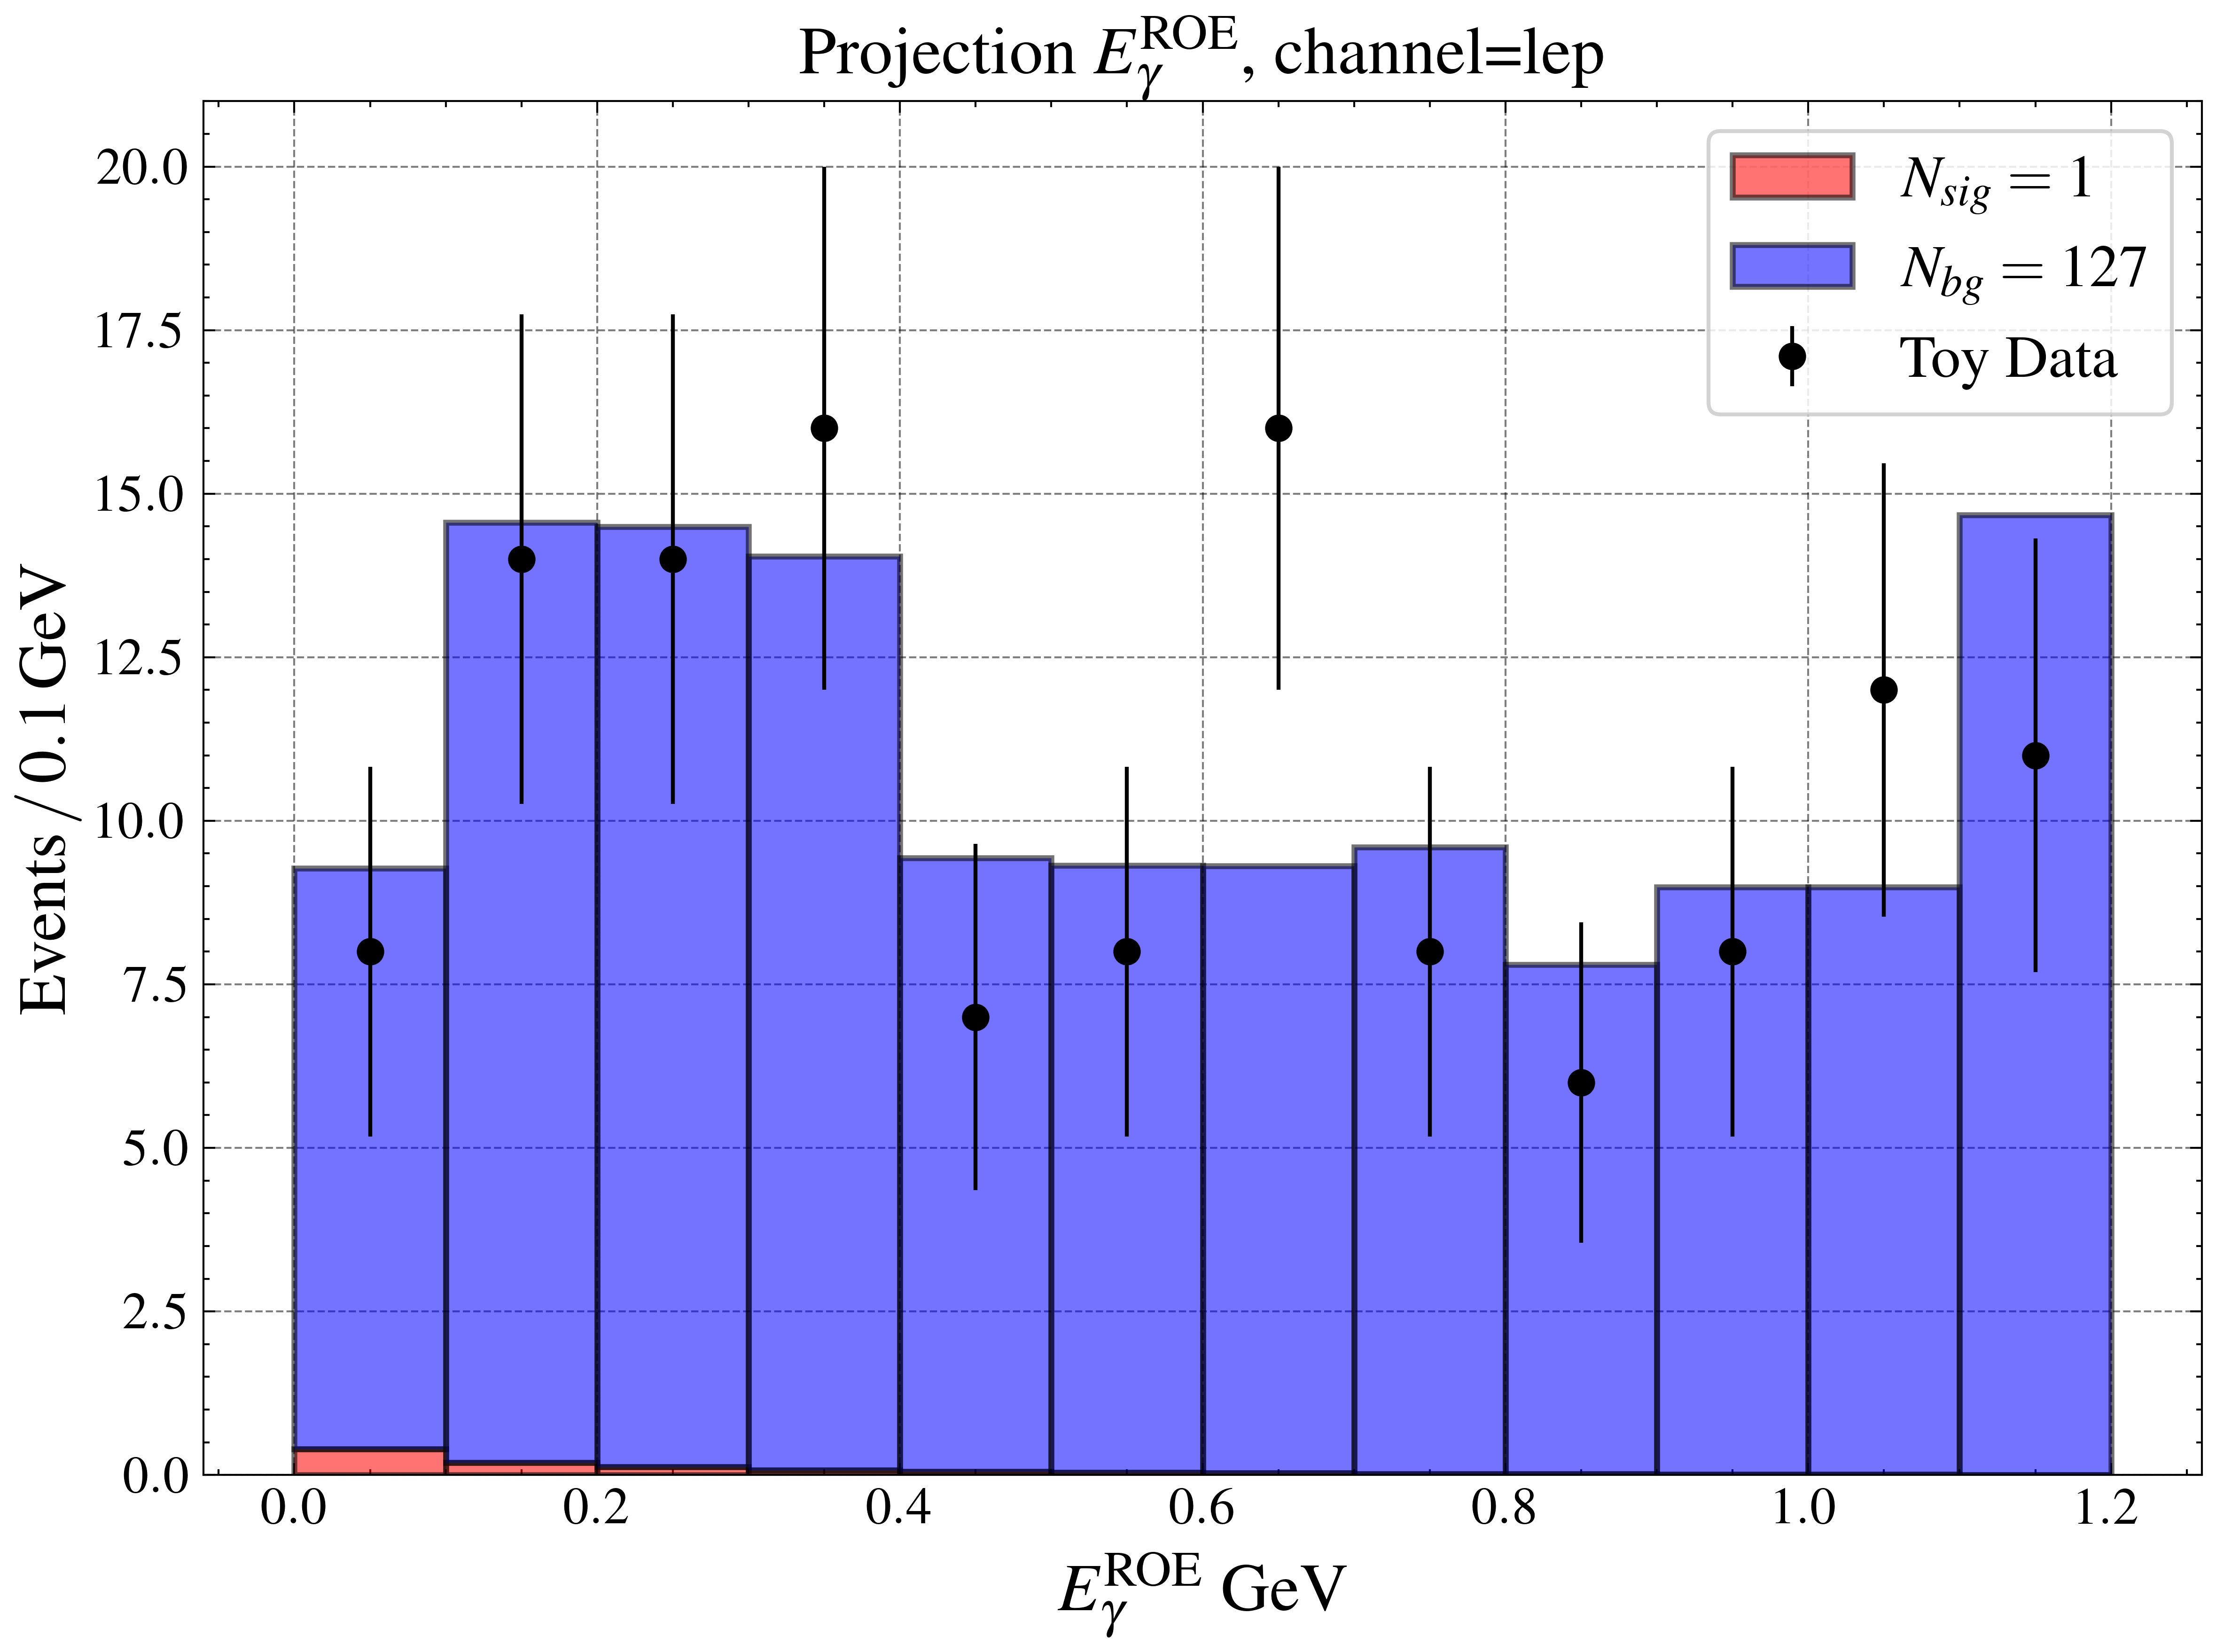

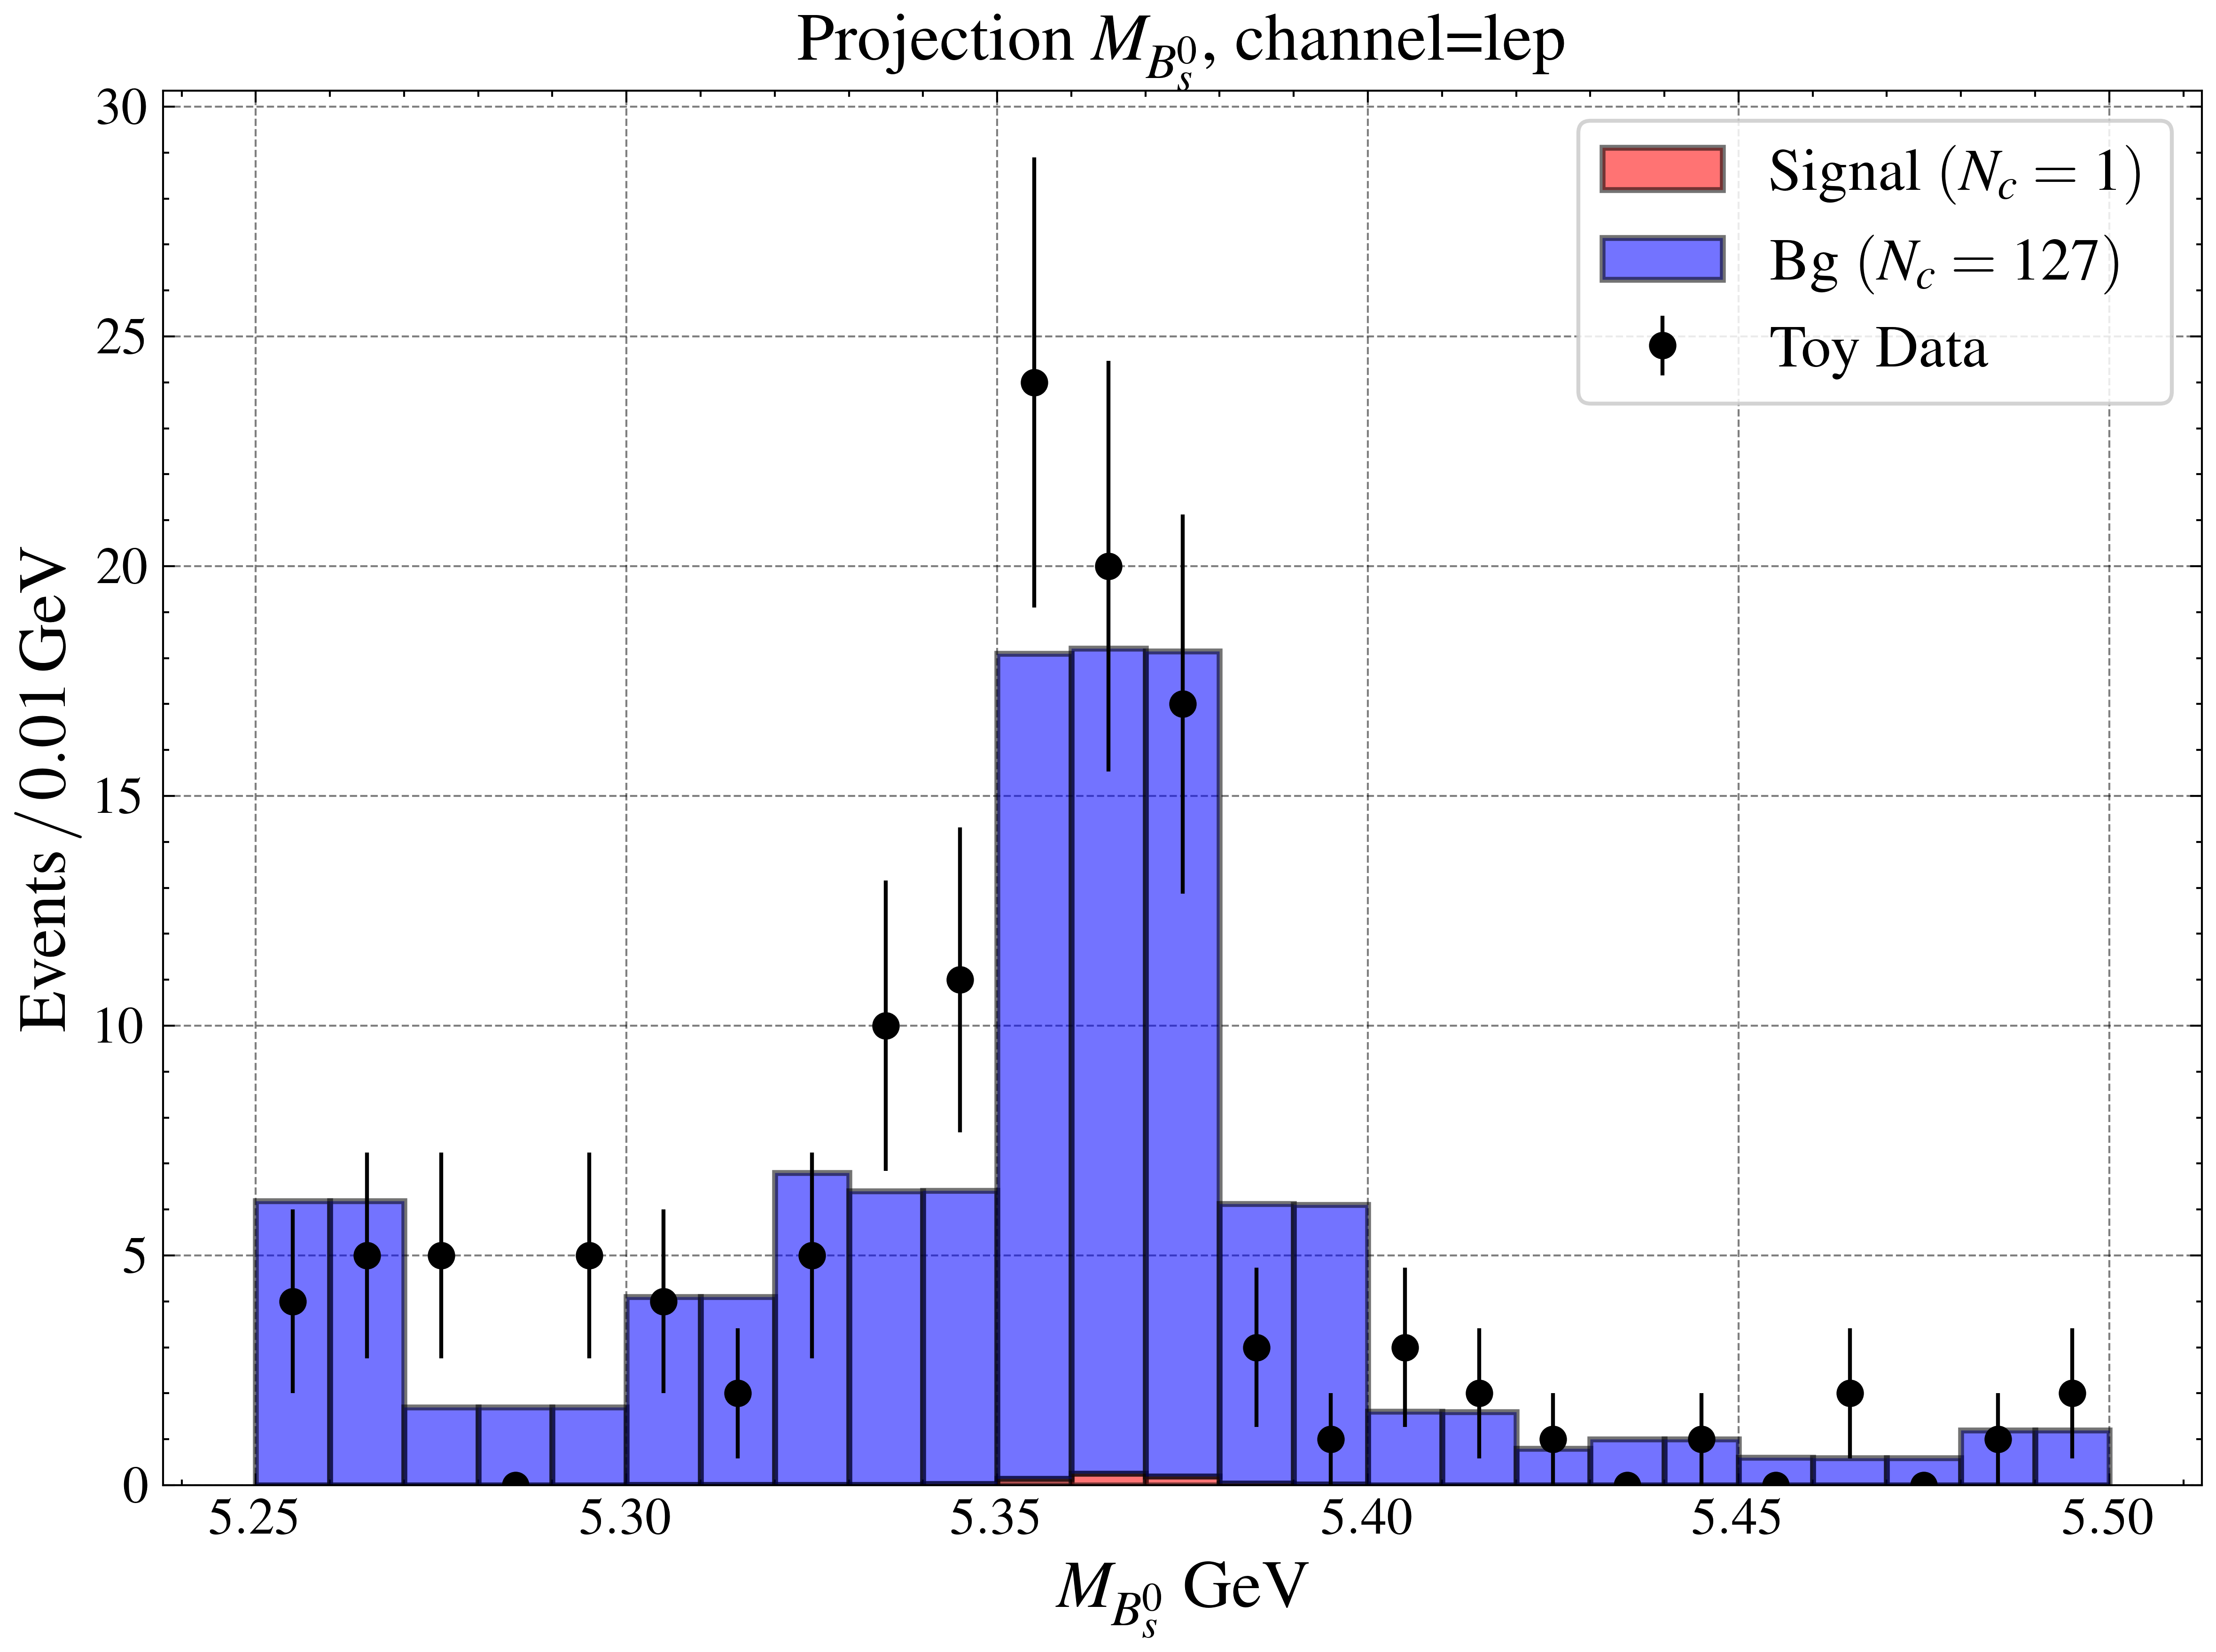

0.00013335085330701268
1887.5316648761723


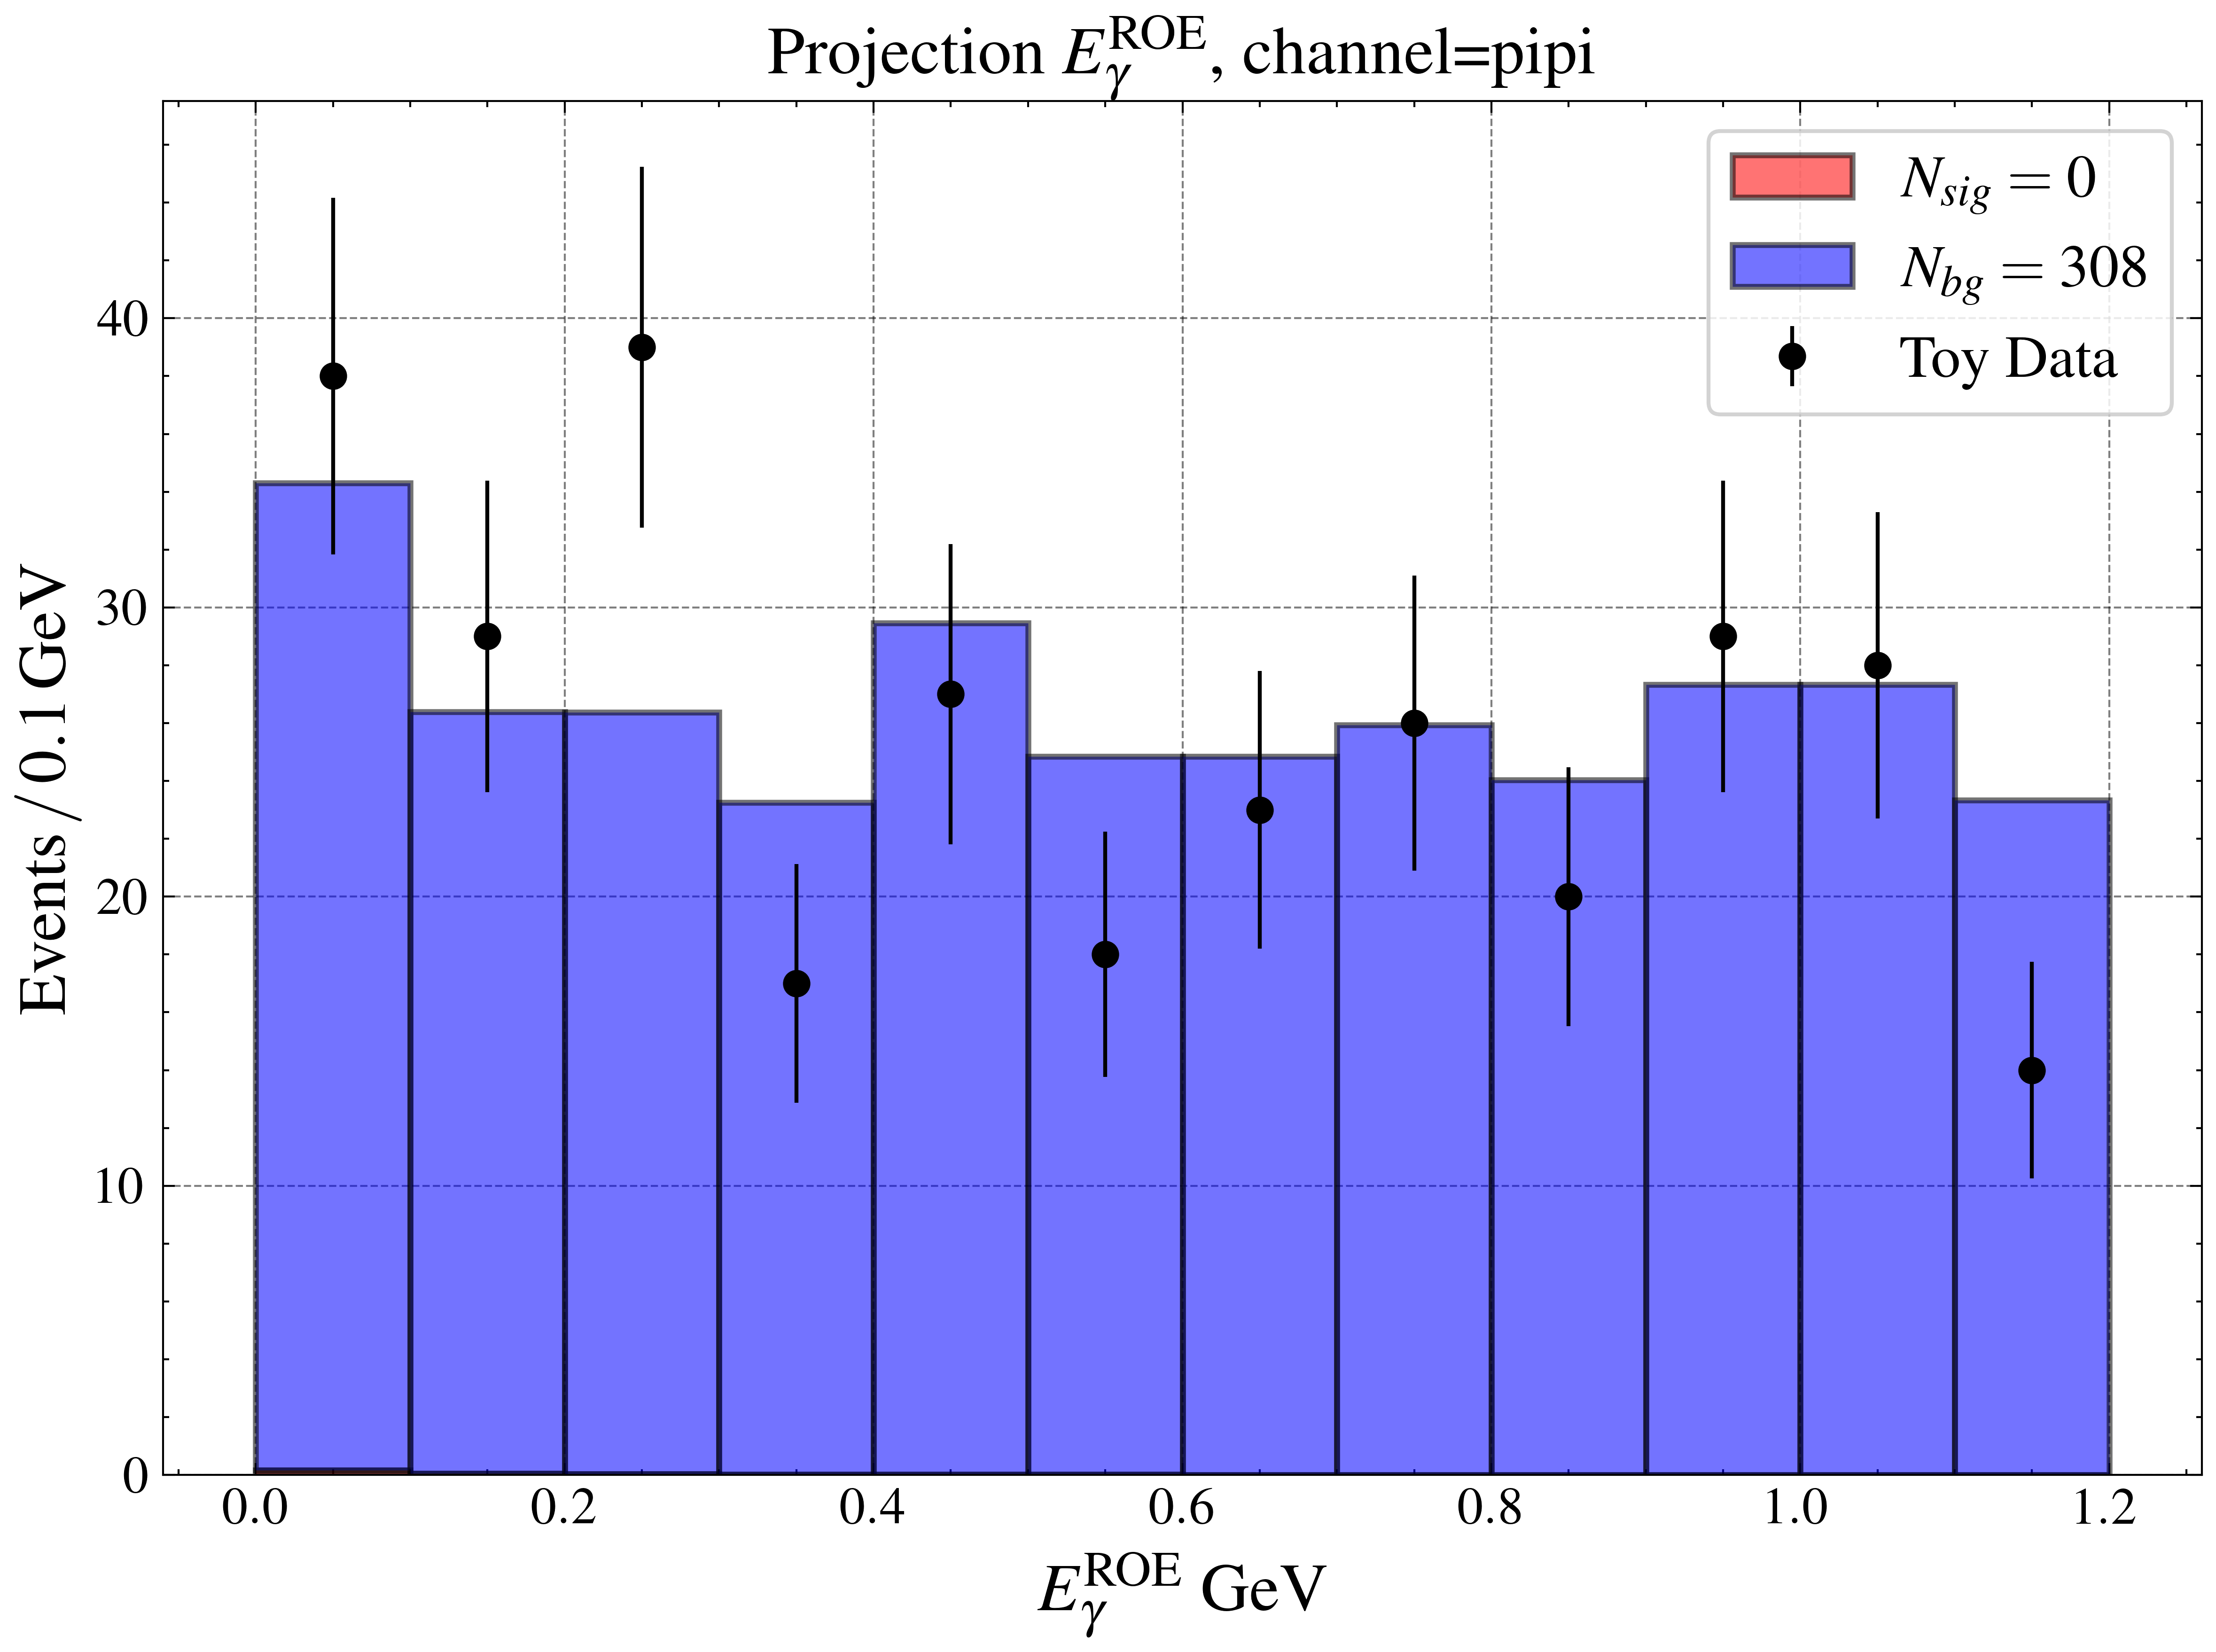

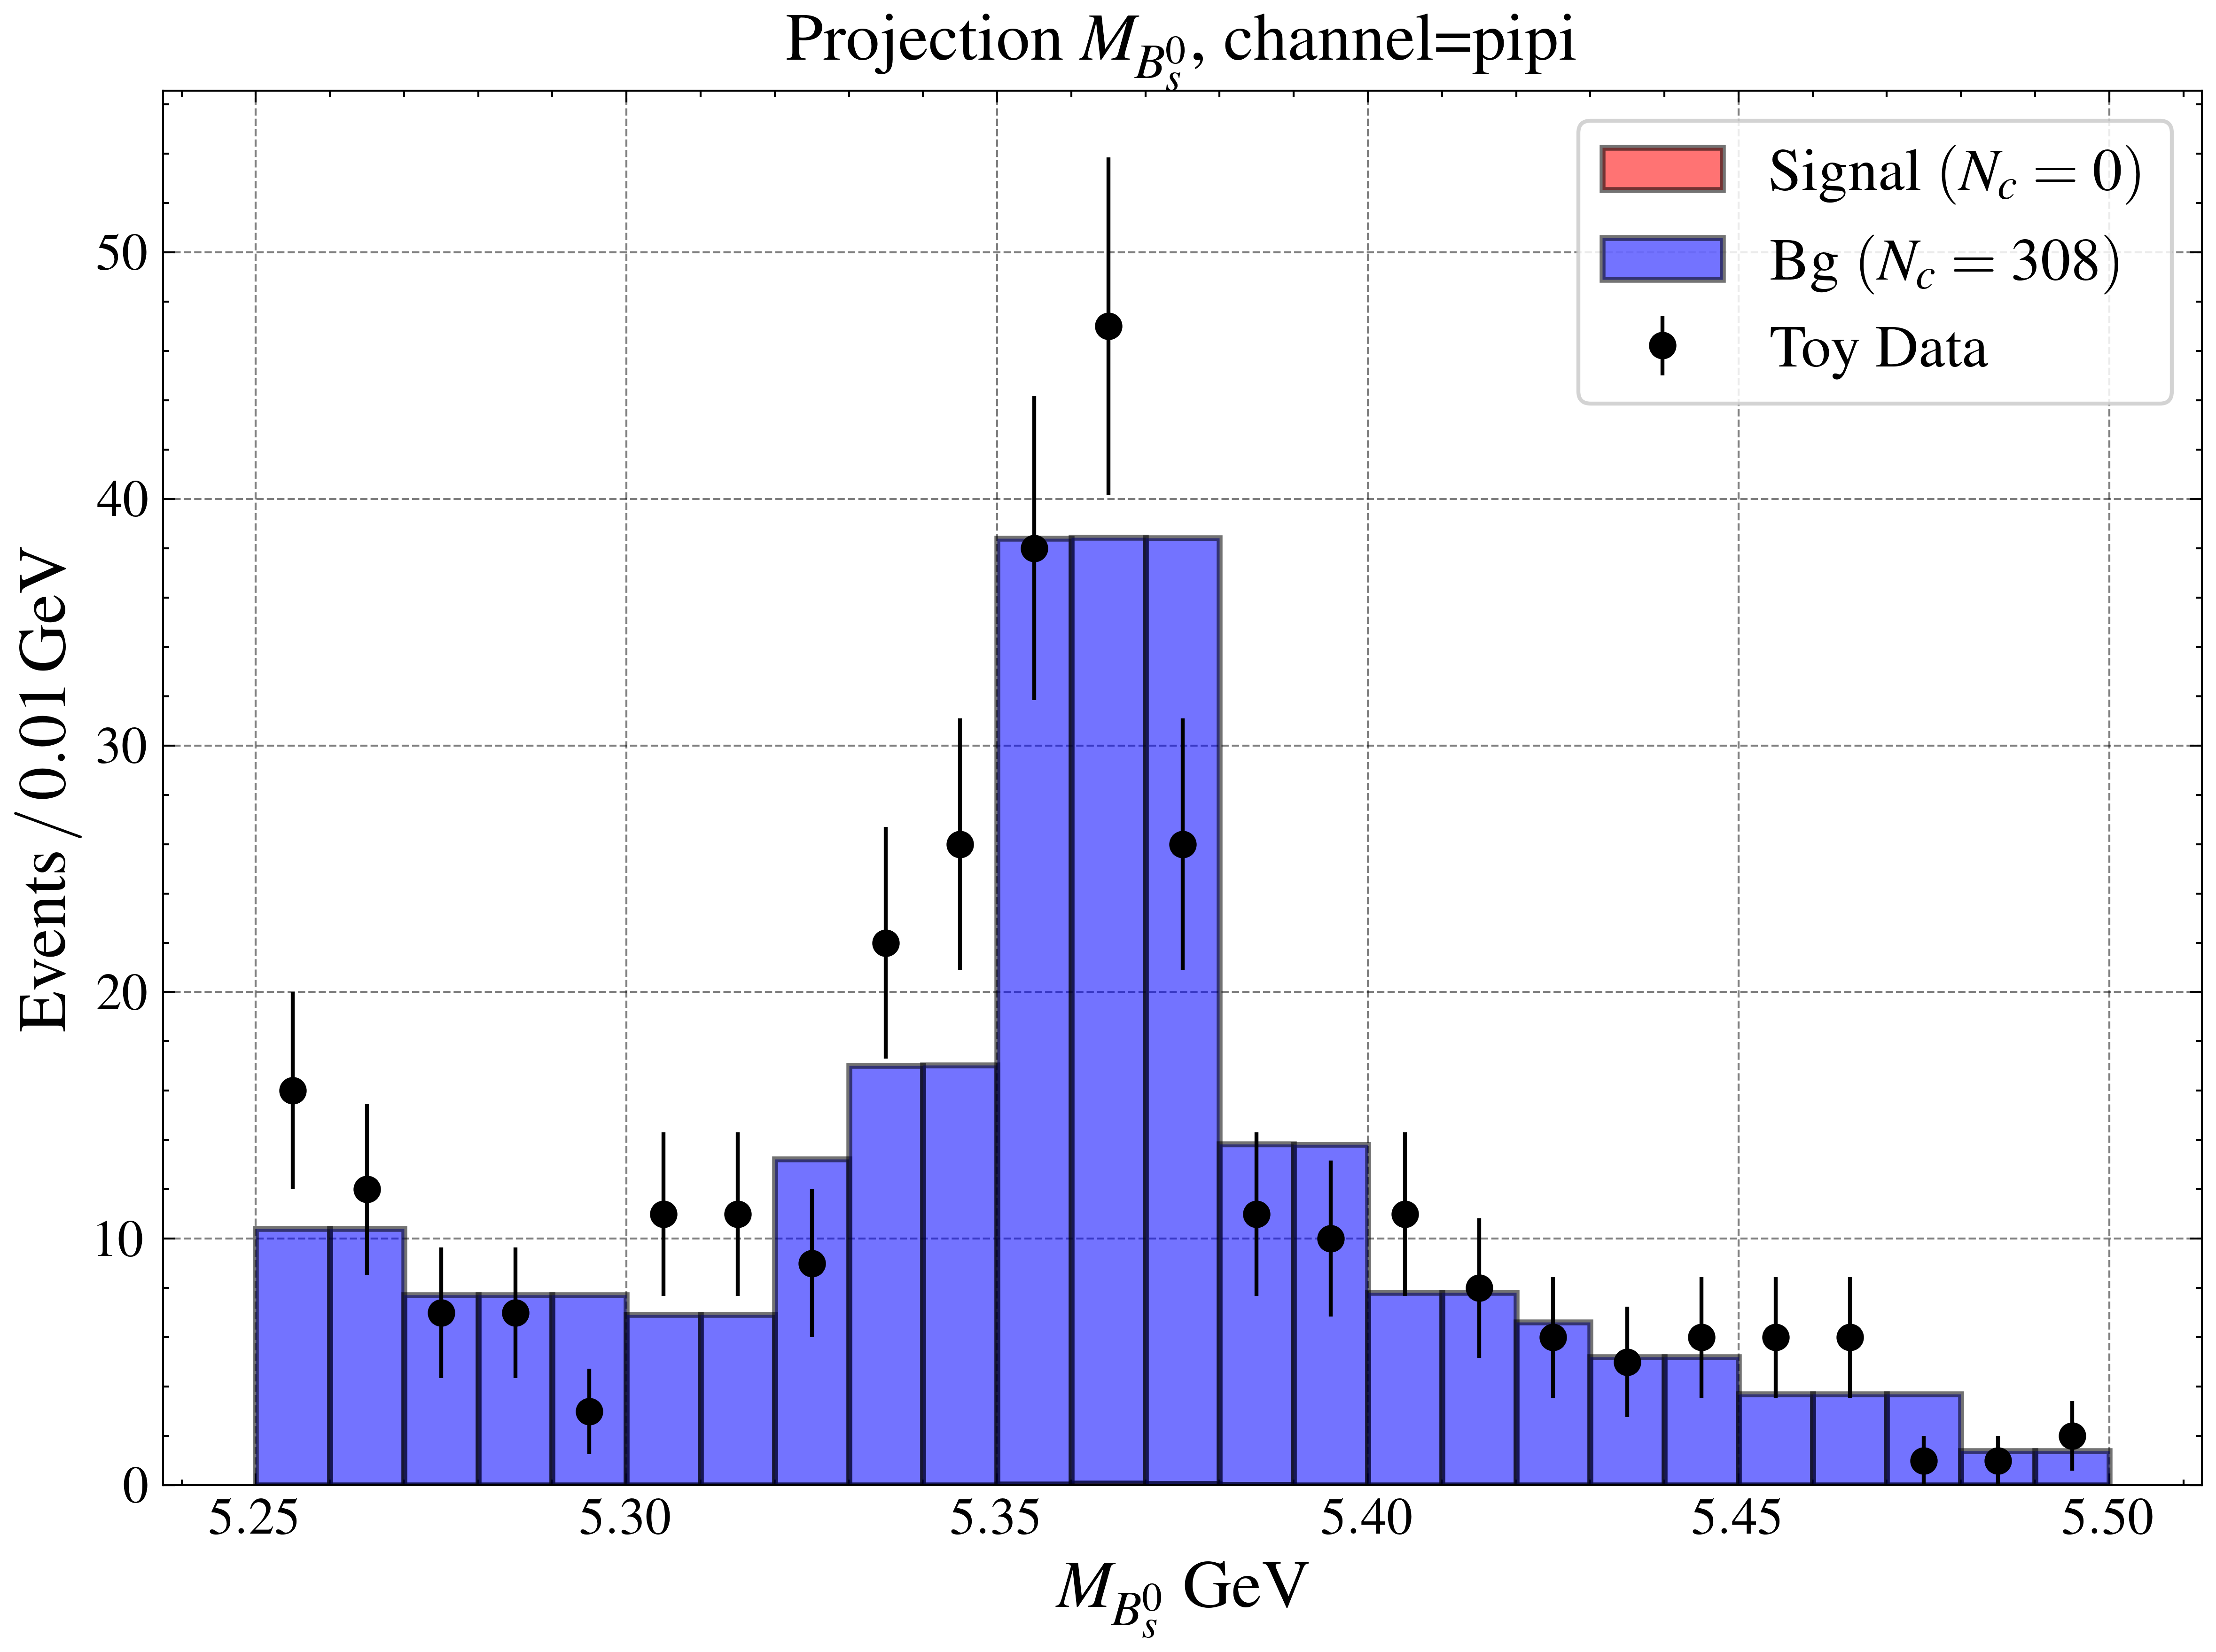

-4.006426221436765e-05
6048.24


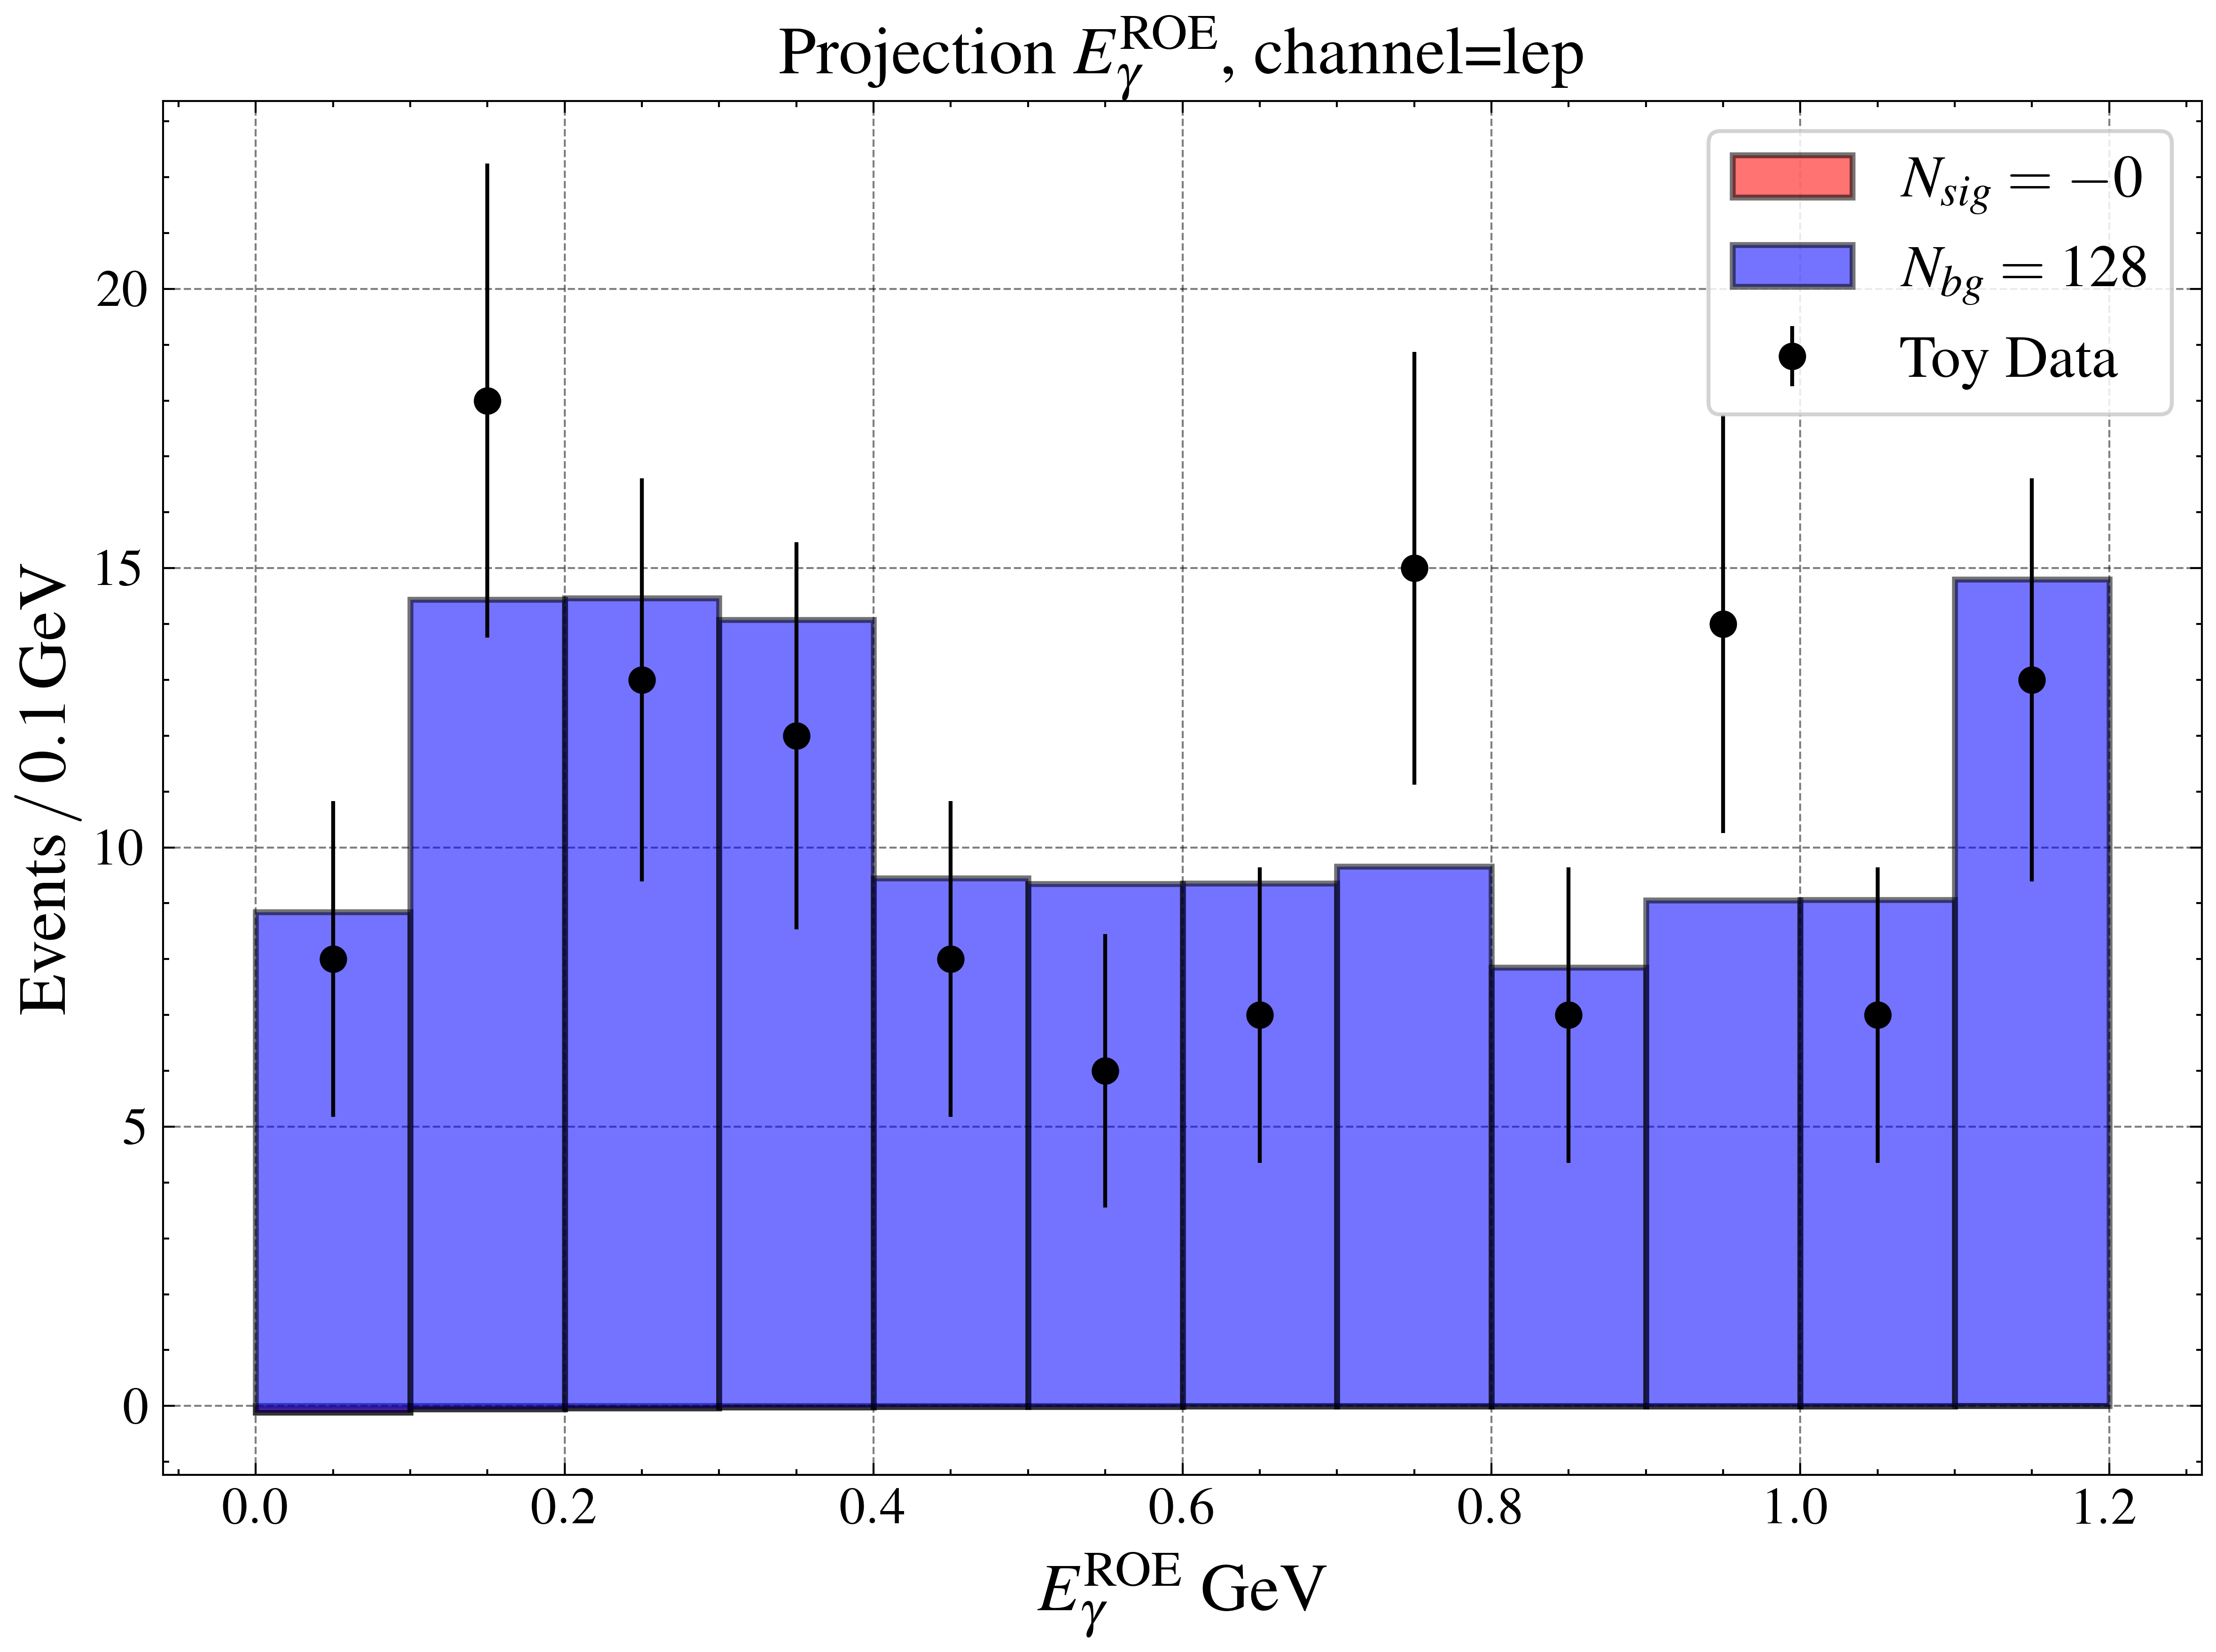

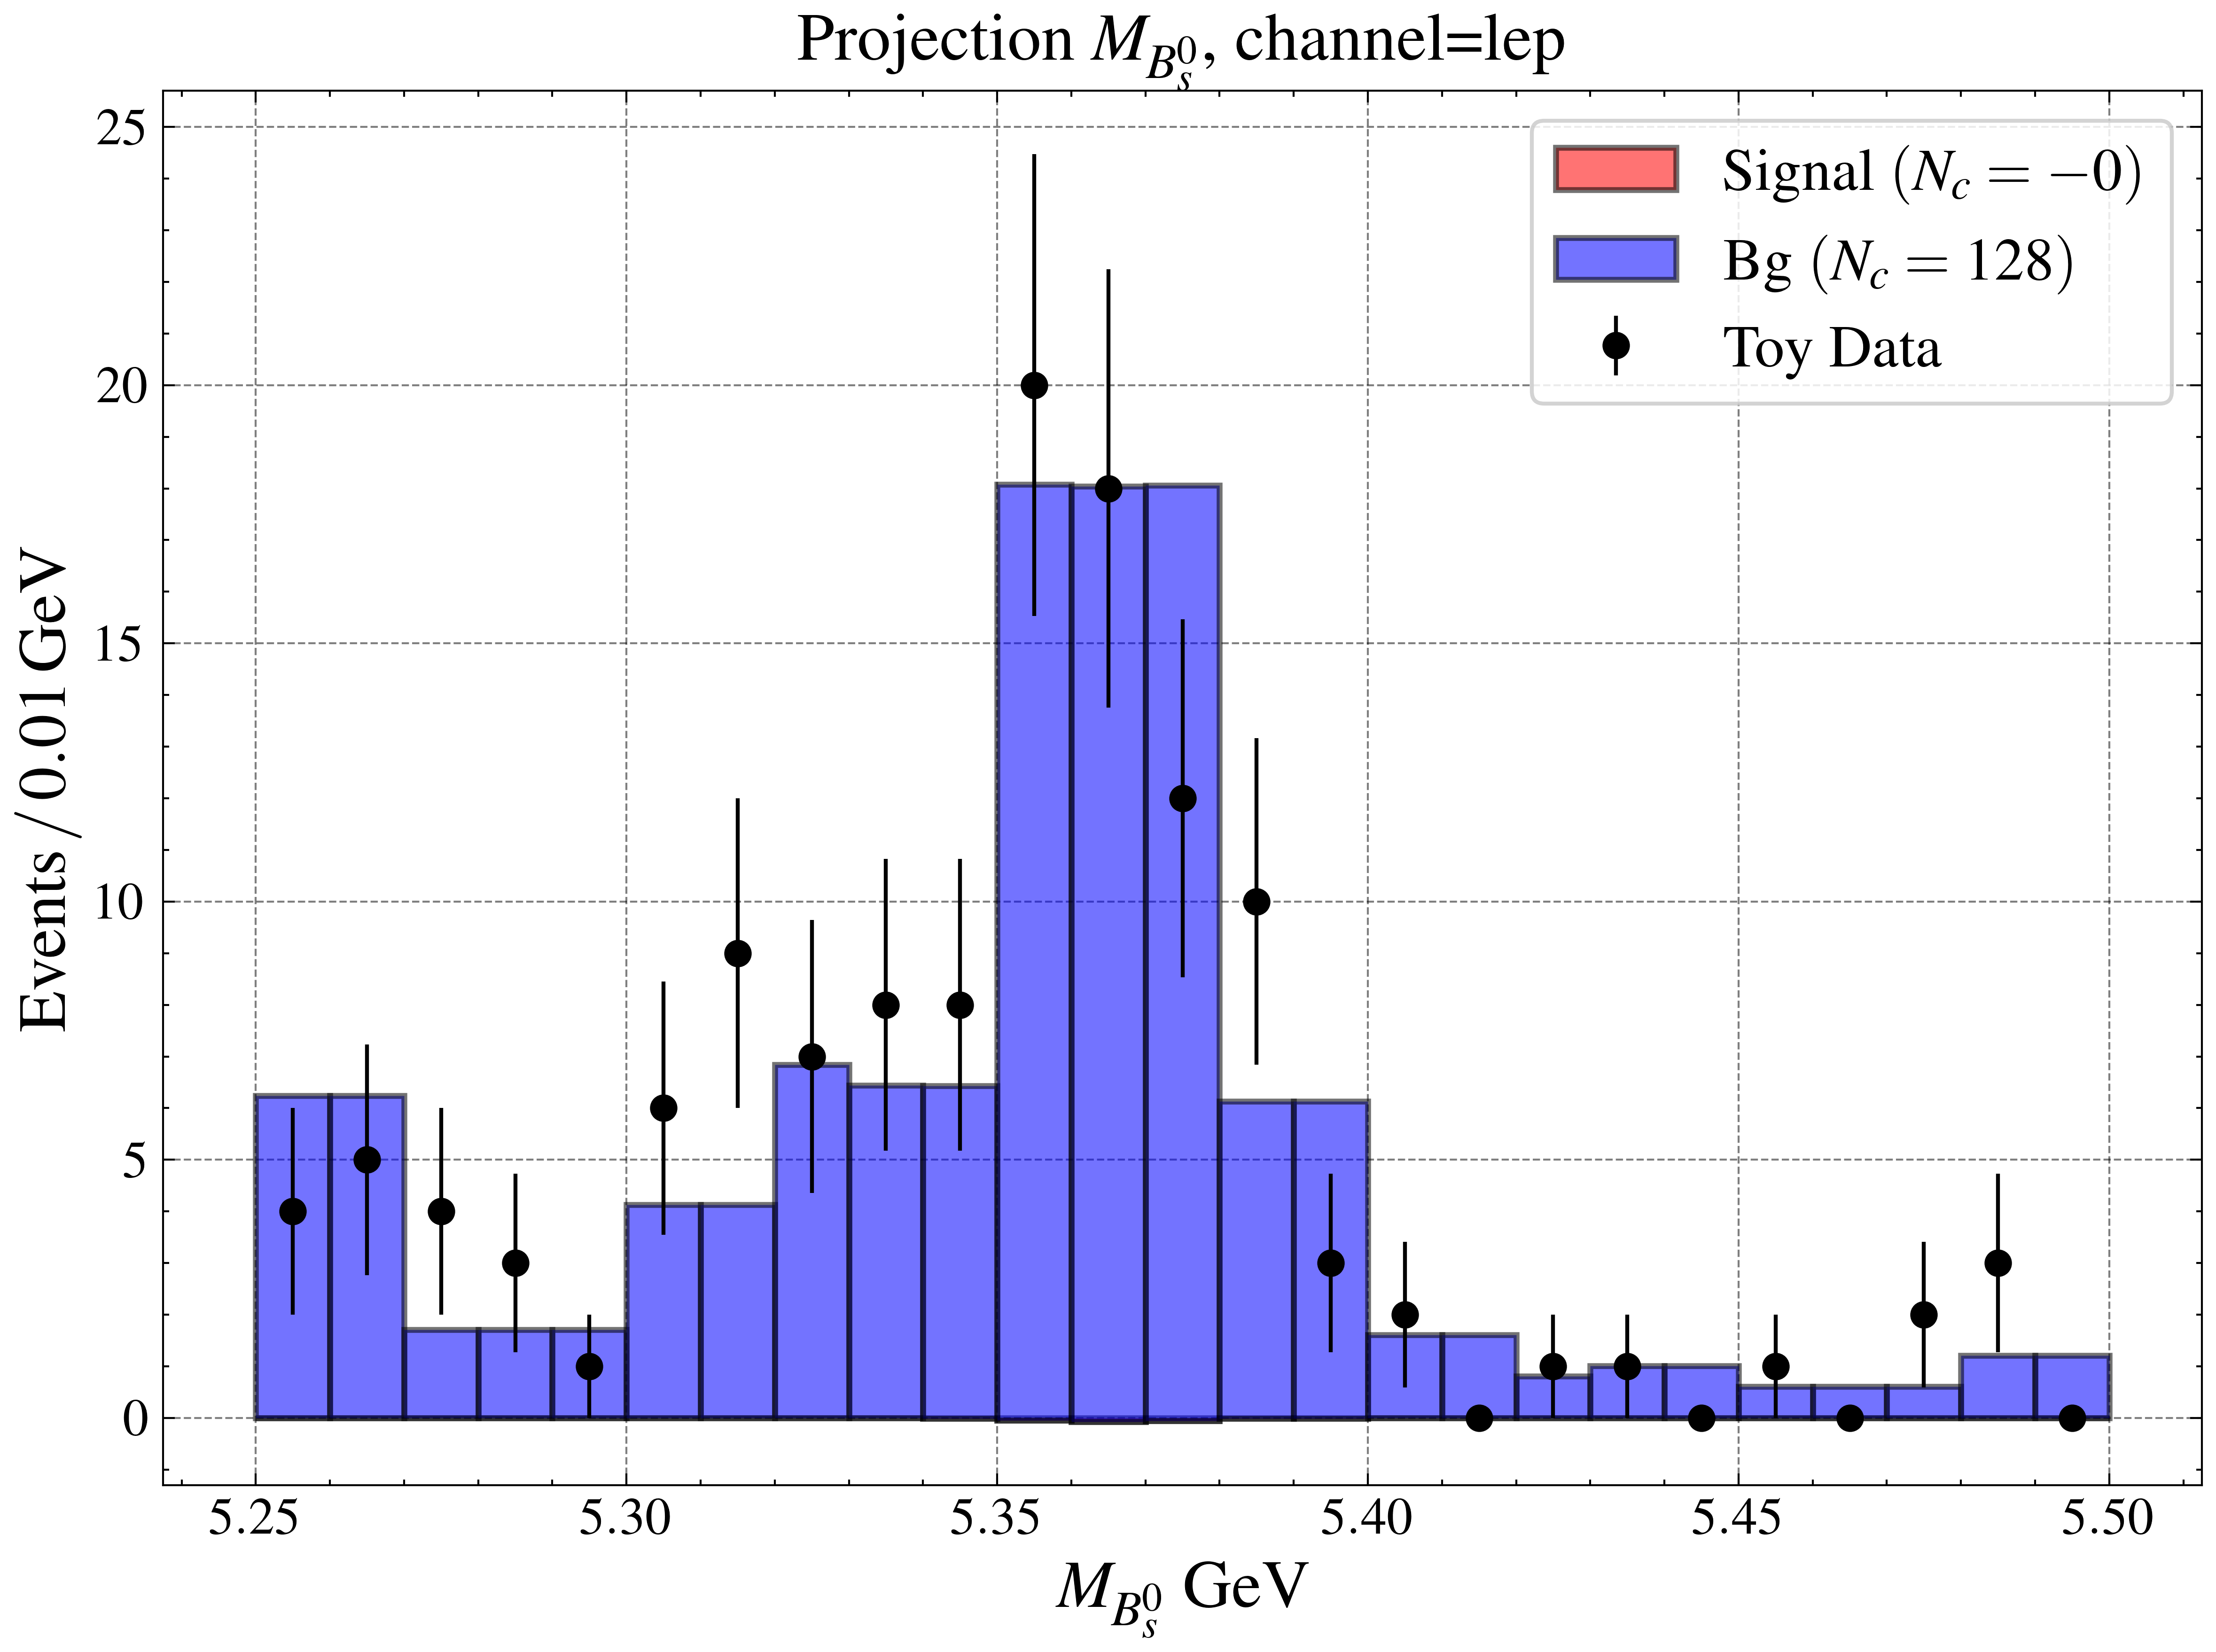

-4.006426221436765e-05
1887.5316648761723


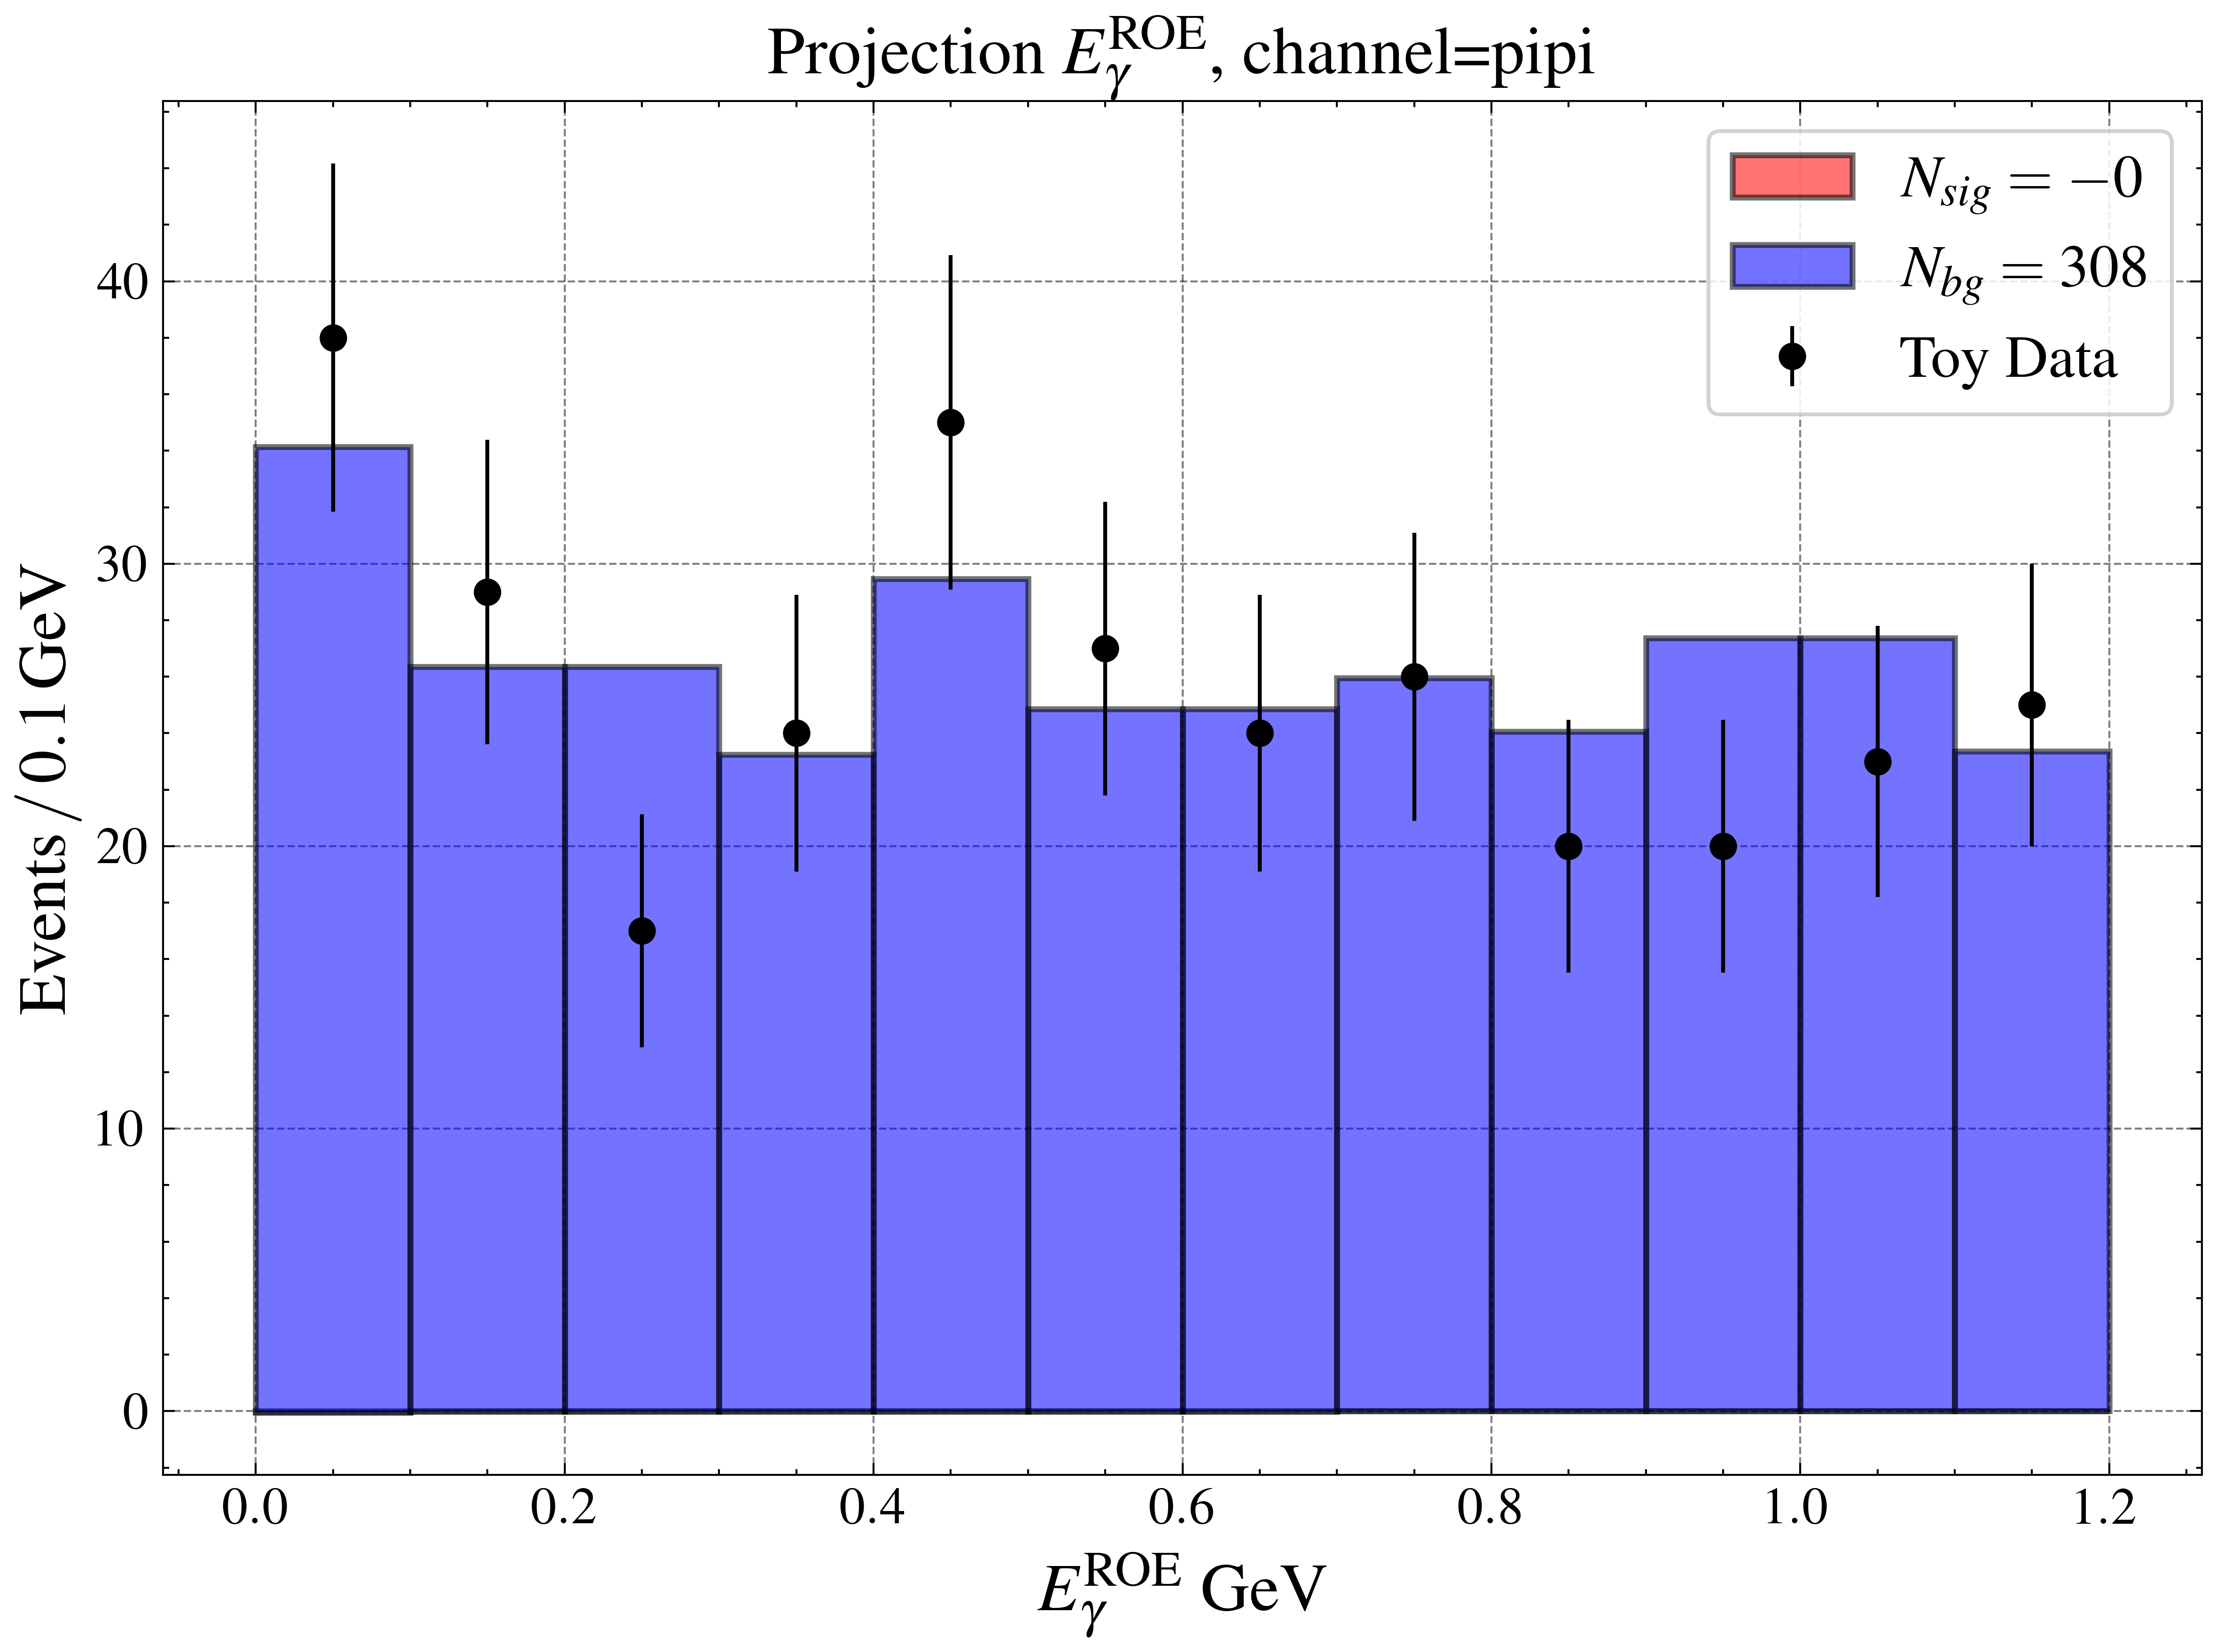

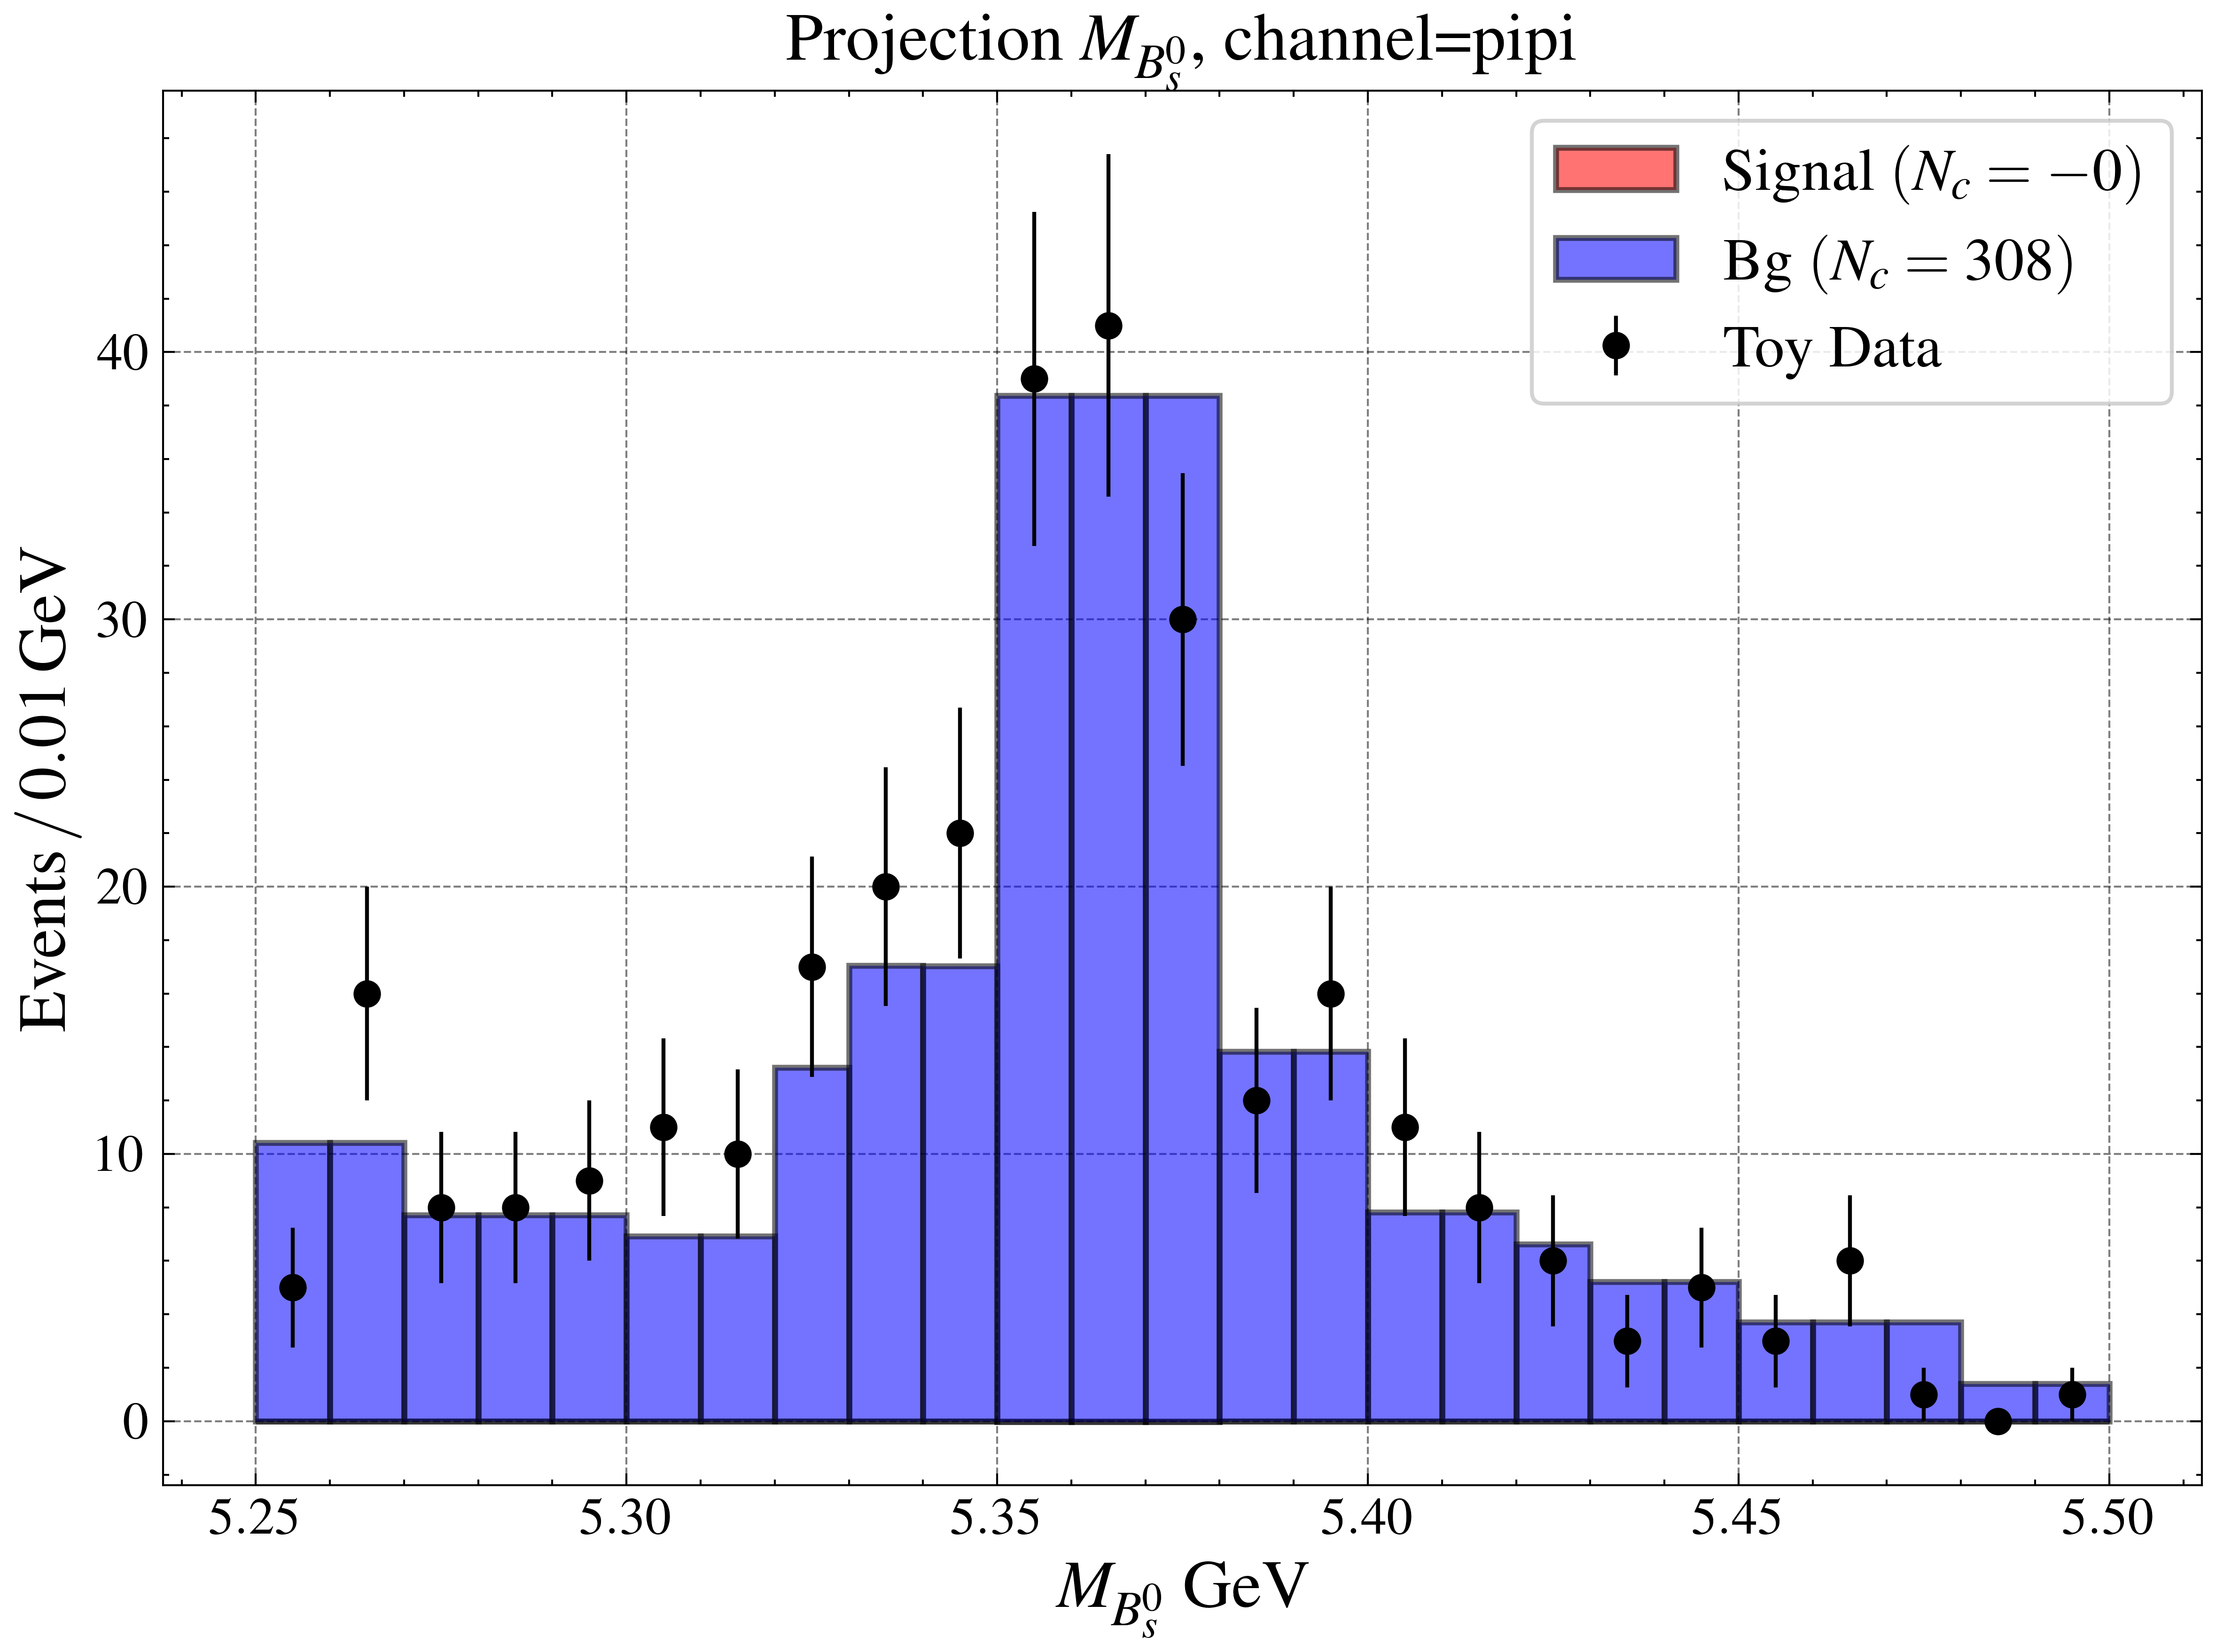

In [4]:
rng = np.random.default_rng(12345)
n_toys = 100

# Загрузка форм, эталонных N_bg и eps
pdfs, Nbg_truth, EPS = {}, {}, {}
for ch in CHANNELS:
    f_sig_ch, f_bg_ch, N_bg_ch = load_channel_objects(ch)
    pdfs[ch] = (f_sig_ch, f_bg_ch)
    Nbg_truth[ch] = N_bg_ch
    EPS[ch] = load_channel_eps(ch)

# размер той-набора по каналу (как прежде: N_bg/6)
def toy_size(ch): 
    return max(1, int(Nbg_truth[ch] / 6))

# хранилища результатов
Btt_list, Btt_errs, Ntt_list = [], [], []
Nbgfit_per_ch_list = []  # по желанию: для контроля

# подготовка сеток для проекций
Xg, Yg = np.meshgrid(x_centers, y_centers, indexing='ij')

# создадим выходные каталоги
Path("output").mkdir(parents=True, exist_ok=True)
Path("results").mkdir(parents=True, exist_ok=True)

for i in range(n_toys):
    # --- 1) генерация той-данных по каналам (фон-только)
    ch_data = {}
    for ch in CHANNELS:
        size = toy_size(ch)
        toy = gen_toy_nd(
            pdf_func=pdfs[ch][1],           # f_bg
            bounds=[[0, 1.2], [5.25, 5.5]],
            size=size,
            grid_points=100,
            rng=rng
        )
        ch_data[ch] = toy.T  # (2, n)

    # --- 2) параметры, границы
    args0 = {"B_tt": 0.0}  # старт для общего сигнала
    bounds = {}
    # масштаб для разумных границ на N_tt
    scale_tt = sum(toy_size(ch) for ch in CHANNELS)
    bounds["B_tt"] = (-1, 1)  # при желании можно (0, 2*scale_tt)

    for ch in CHANNELS:
        n0 = toy_size(ch)
        args0[f"N_bg_fit_{ch}"] = float(n0)
        bounds[f"N_bg_fit_{ch}"] = (-Nbg_truth[ch]/6.0, 2.0*Nbg_truth[ch])

    # --- 3) комбинированный экстенд-фит
    rez, errs = combined_max_lik_ext_eps(ch_data, pdfs, EPS, args0, bounds=bounds, err_need=True)

    # --- 4) сбор результатов
    Btt = rez["B_tt"]
    err_Ntt = errs.get("B_tt", np.nan)
    Btt_list.append(Btt)
    Btt_errs.append(err_Ntt)

    Nbgfit_per_ch = {ch: rez[f"N_bg_fit_{ch}"] for ch in CHANNELS}
    Nbgfit_per_ch_list.append(Nbgfit_per_ch)
    Ntt_list.append(7.9 * 2 * 10e6 * sum(list([EPS[_] for _ in EPS])) * Btt)
    # --- 5) визуальные проекции только для первых двух той и двух каналов
    if i < 2:
        demo_channels = CHANNELS[:2]
        for ch in demo_channels:
            print(Btt)
            toy_xy = ch_data[ch]           # (2, n)
            xvals, yvals = toy_xy[0], toy_xy[1]

            fsig_ch, fbg_ch = pdfs[ch]
            e = EPS[ch]
            print(7.9 * 2 * 10e6 * e)
            Nsig_c = Btt * 7.9 * 2 * 10e6 * e
            Nbg_c  = rez[f"N_bg_fit_{ch}"]

            src_sig = fsig_ch([Xg, Yg]) * Nsig_c
            src_bg  = fbg_ch([Xg, Yg])  * Nbg_c

            fit_proj_x_sig = np.trapz(src_sig, y_centers, axis=1) * wbin_x
            fit_proj_x_bg  = np.trapz(src_bg,  y_centers, axis=1) * wbin_x
            fit_proj_y_sig = np.trapz(src_sig, x_centers, axis=0) * wbin_y
            fit_proj_y_bg  = np.trapz(src_bg,  x_centers, axis=0) * wbin_y

            counts_x, _ = np.histogram(xvals, bins=bins_x)
            counts_y, _ = np.histogram(yvals, bins=bins_y)

            # --- проекция по E_gamma^{ROE}
            plt.figure(figsize=(8, 6))
            plt.errorbar(x_centers, counts_x, yerr=np.sqrt(counts_x), fmt='o', label="Toy Data")
            plt.hist([x_centers, x_centers],
                        bins=bins_x,
                        weights=[fit_proj_x_sig, fit_proj_x_bg],
                        stacked=True,
                        alpha=0.55,
                        edgecolor="black", linewidth=1.5,
                        label=[rf"$N_{{sig}}={Nsig_c:.0f}$",
                            rf"$N_{{bg}}={Nbg_c:.0f}$"])
            plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}\ \mathrm{GeV}$")
            plt.ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_x}\,\mathrm{{GeV}}$')
            plt.title(rf"Projection $E_\gamma^{{\mathrm{{ROE}}}}$, channel={ch}")
            plt.legend(loc='upper right', framealpha=0.85)
            plt.tight_layout()
            plt.savefig(f"output/toy_mc_projX_{ch}_{i}.pdf", dpi=700)
            plt.show()

            # --- проекция по M_{B_s^0}
            plt.figure(figsize=(8, 6))
            plt.errorbar(y_centers, counts_y, yerr=np.sqrt(counts_y), fmt='o', label="Toy Data")
            plt.hist([y_centers, y_centers],
                        bins=bins_y,
                        weights=[fit_proj_y_sig, fit_proj_y_bg],
                        stacked=True,
                        alpha=0.55,
                        edgecolor="black", linewidth=1.5,
                        label=[rf"$\mathrm{{Signal}}\ (N_c={Nsig_c:.0f})$",
                            rf"$\mathrm{{Bg}}\ (N_c={Nbg_c:.0f})$"])
            plt.xlabel(r"$M_{B_s^0}\ \mathrm{GeV}$")
            plt.ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_y}\,\mathrm{{GeV}}$')
            plt.title(rf"Projection $M_{{B_s^0}}$, channel={ch}")
            plt.legend(loc='upper right', framealpha=0.85)
            plt.tight_layout()
            plt.savefig(f"output/toy_mc_projY_{ch}_{i}.pdf", dpi=700)
            plt.show()



In [5]:
B_arr  = np.array(Btt_list, dtype=float)

# pull для B при H0: B=0
bins = np.linspace(-5, 5, 16)
pull = (B_arr - 0.0)
# ... построение гистограммы pull (как у тебя)

# перцентили
B_sorted = np.sort(B_arr)
p95 = float(B_sorted[int(0.95 * len(B_sorted))])
p90 = float(B_sorted[int(0.90 * len(B_sorted))])
print("B_tt 95%:", p95, "  B_tt 90%:", p90)

json_update("results/data_combined.json", {
    "B_tt_95_per": p95,
    "B_tt_90_per": p90,
})

B_tt 95%: 0.0001971148983812565   B_tt 90%: 0.00017169555866947128
Файл 'results/data_combined.json' обновлён или создан заново.


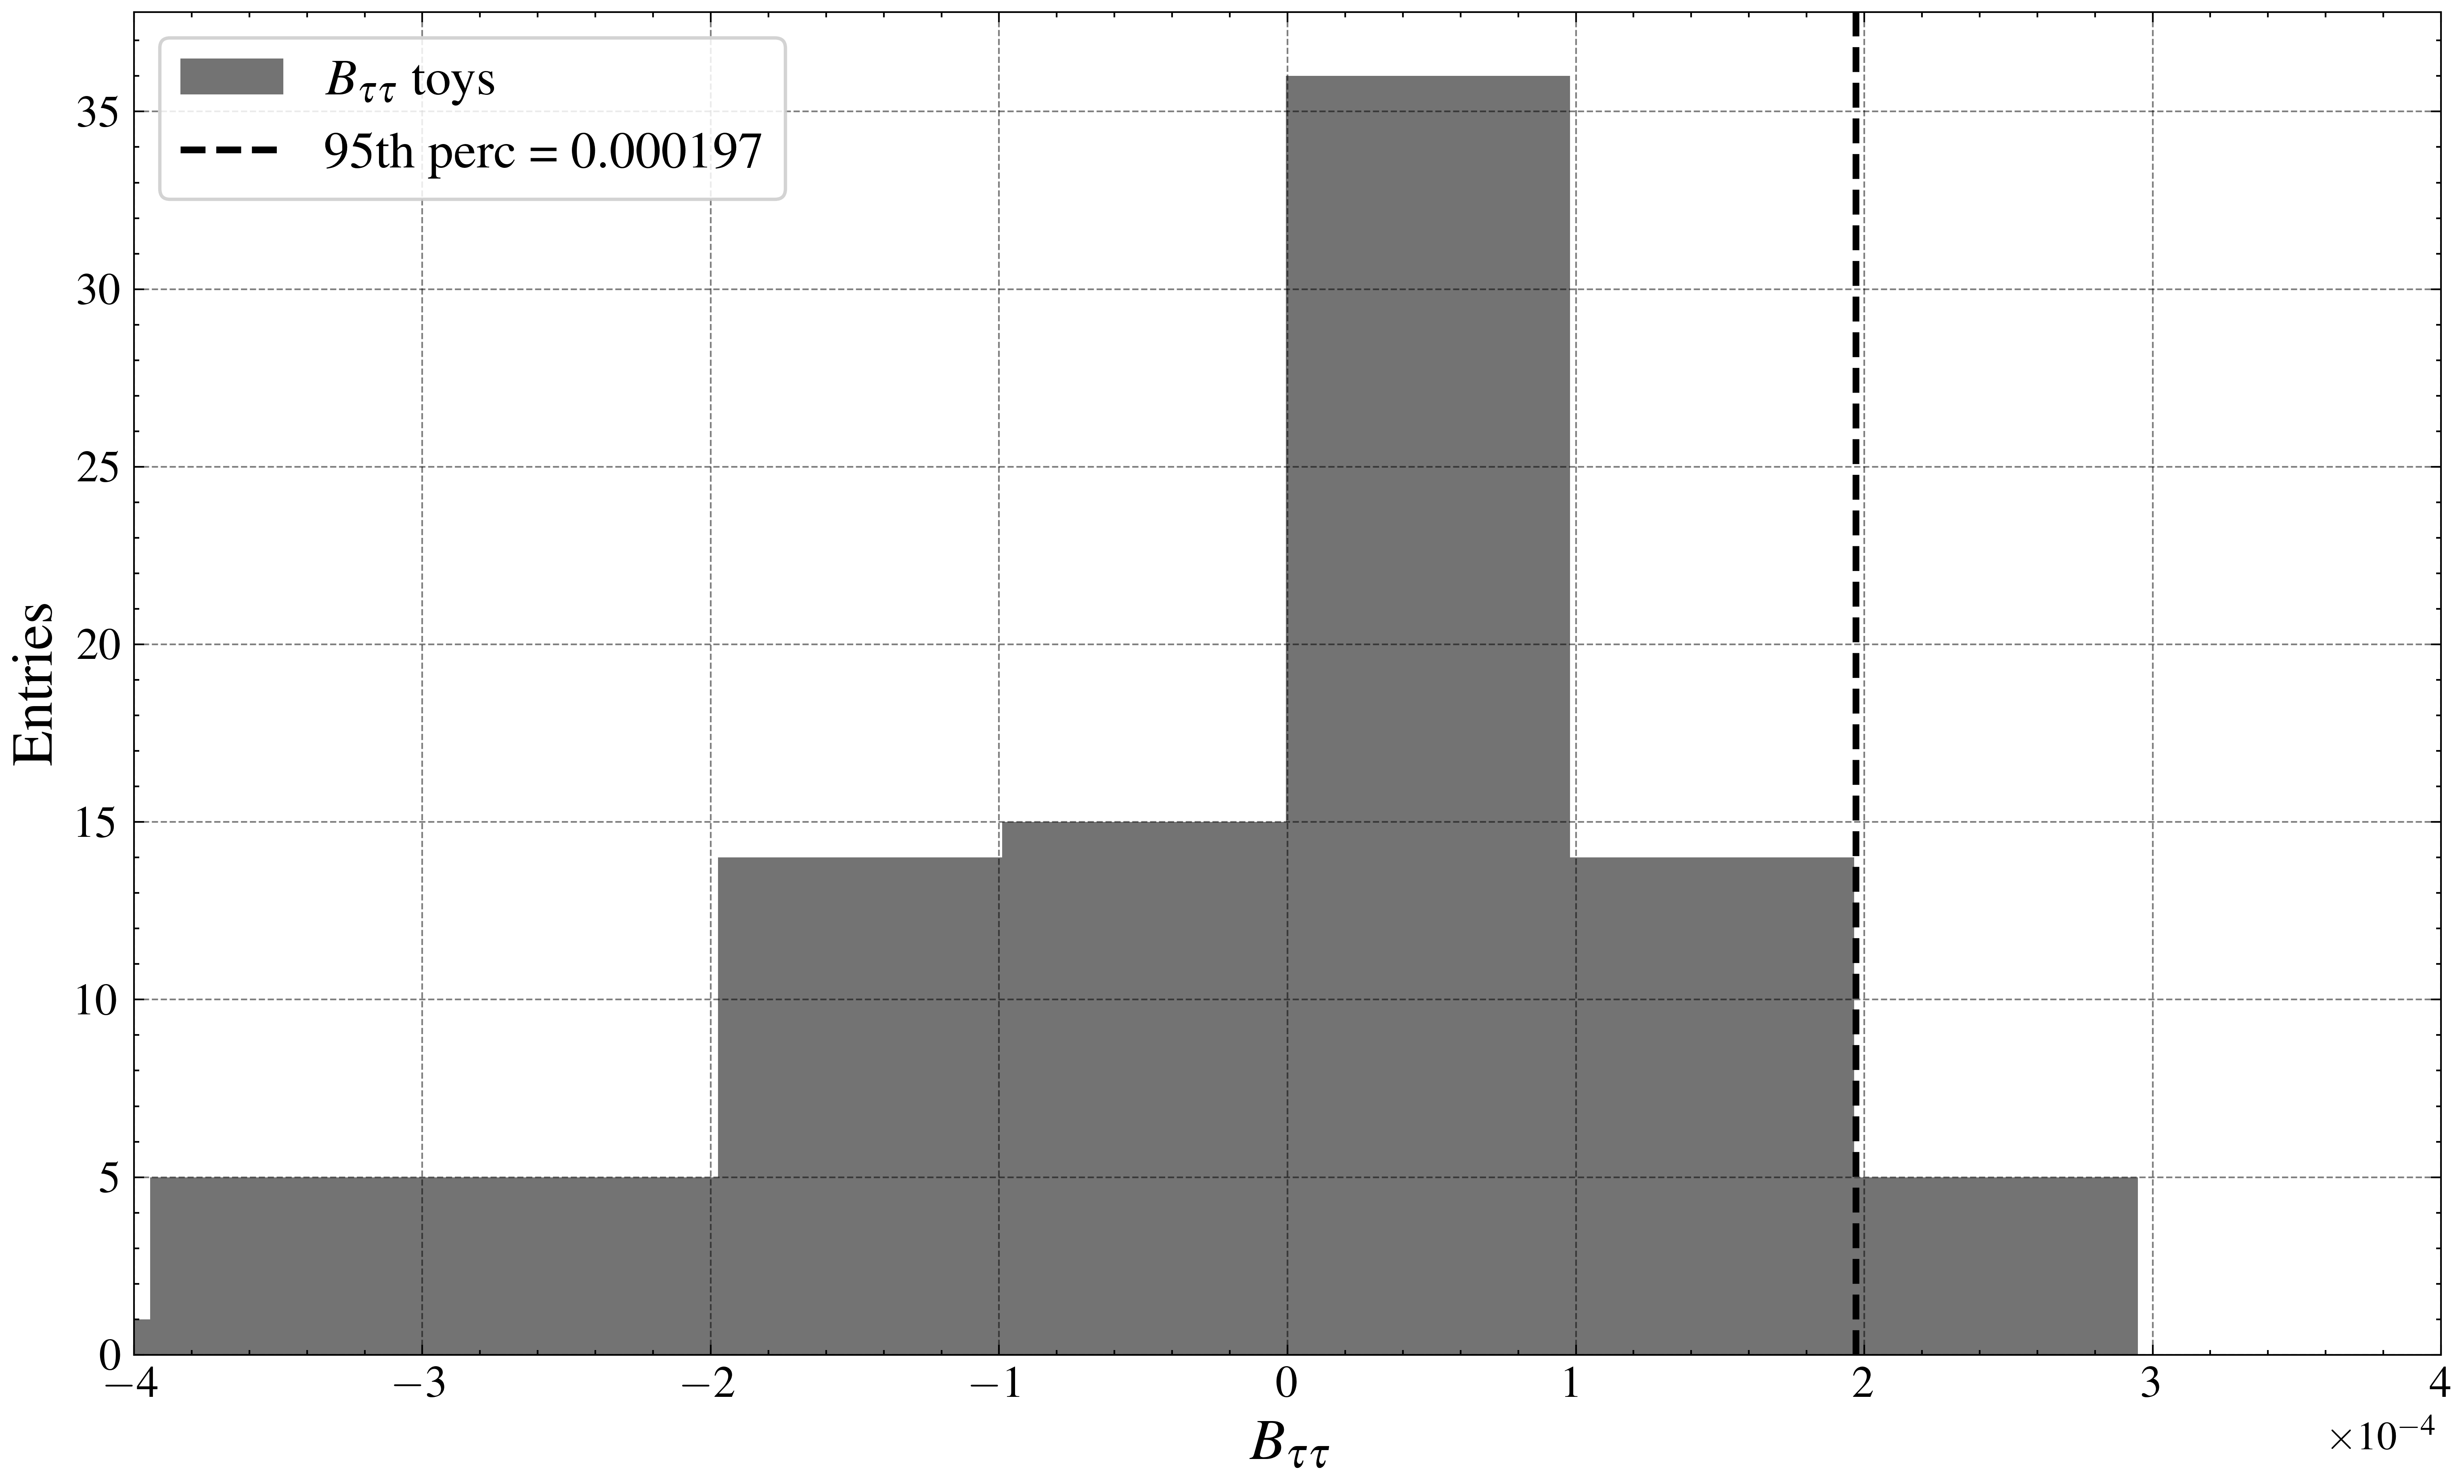

In [6]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
plt.hist(np.array(B_arr),
            alpha=0.55,
            bins = 16,
            label=r'$B_{\tau\tau}$ toys')
plt.axvline(p95, linestyle='--', linewidth=2, label=fr'95th perc = {p95:.3g}')
plt.legend(loc='upper left', framealpha=0.85)
plt.tight_layout()
plt.xlim(-0.0004, 0.0004)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='x', style='sci', scilimits=(-1,1))
ax.xaxis.offsetText.set_fontsize(12)  
plt.xlabel(r'$B_{\tau\tau}$')
plt.ylabel('Entries')
plt.show()


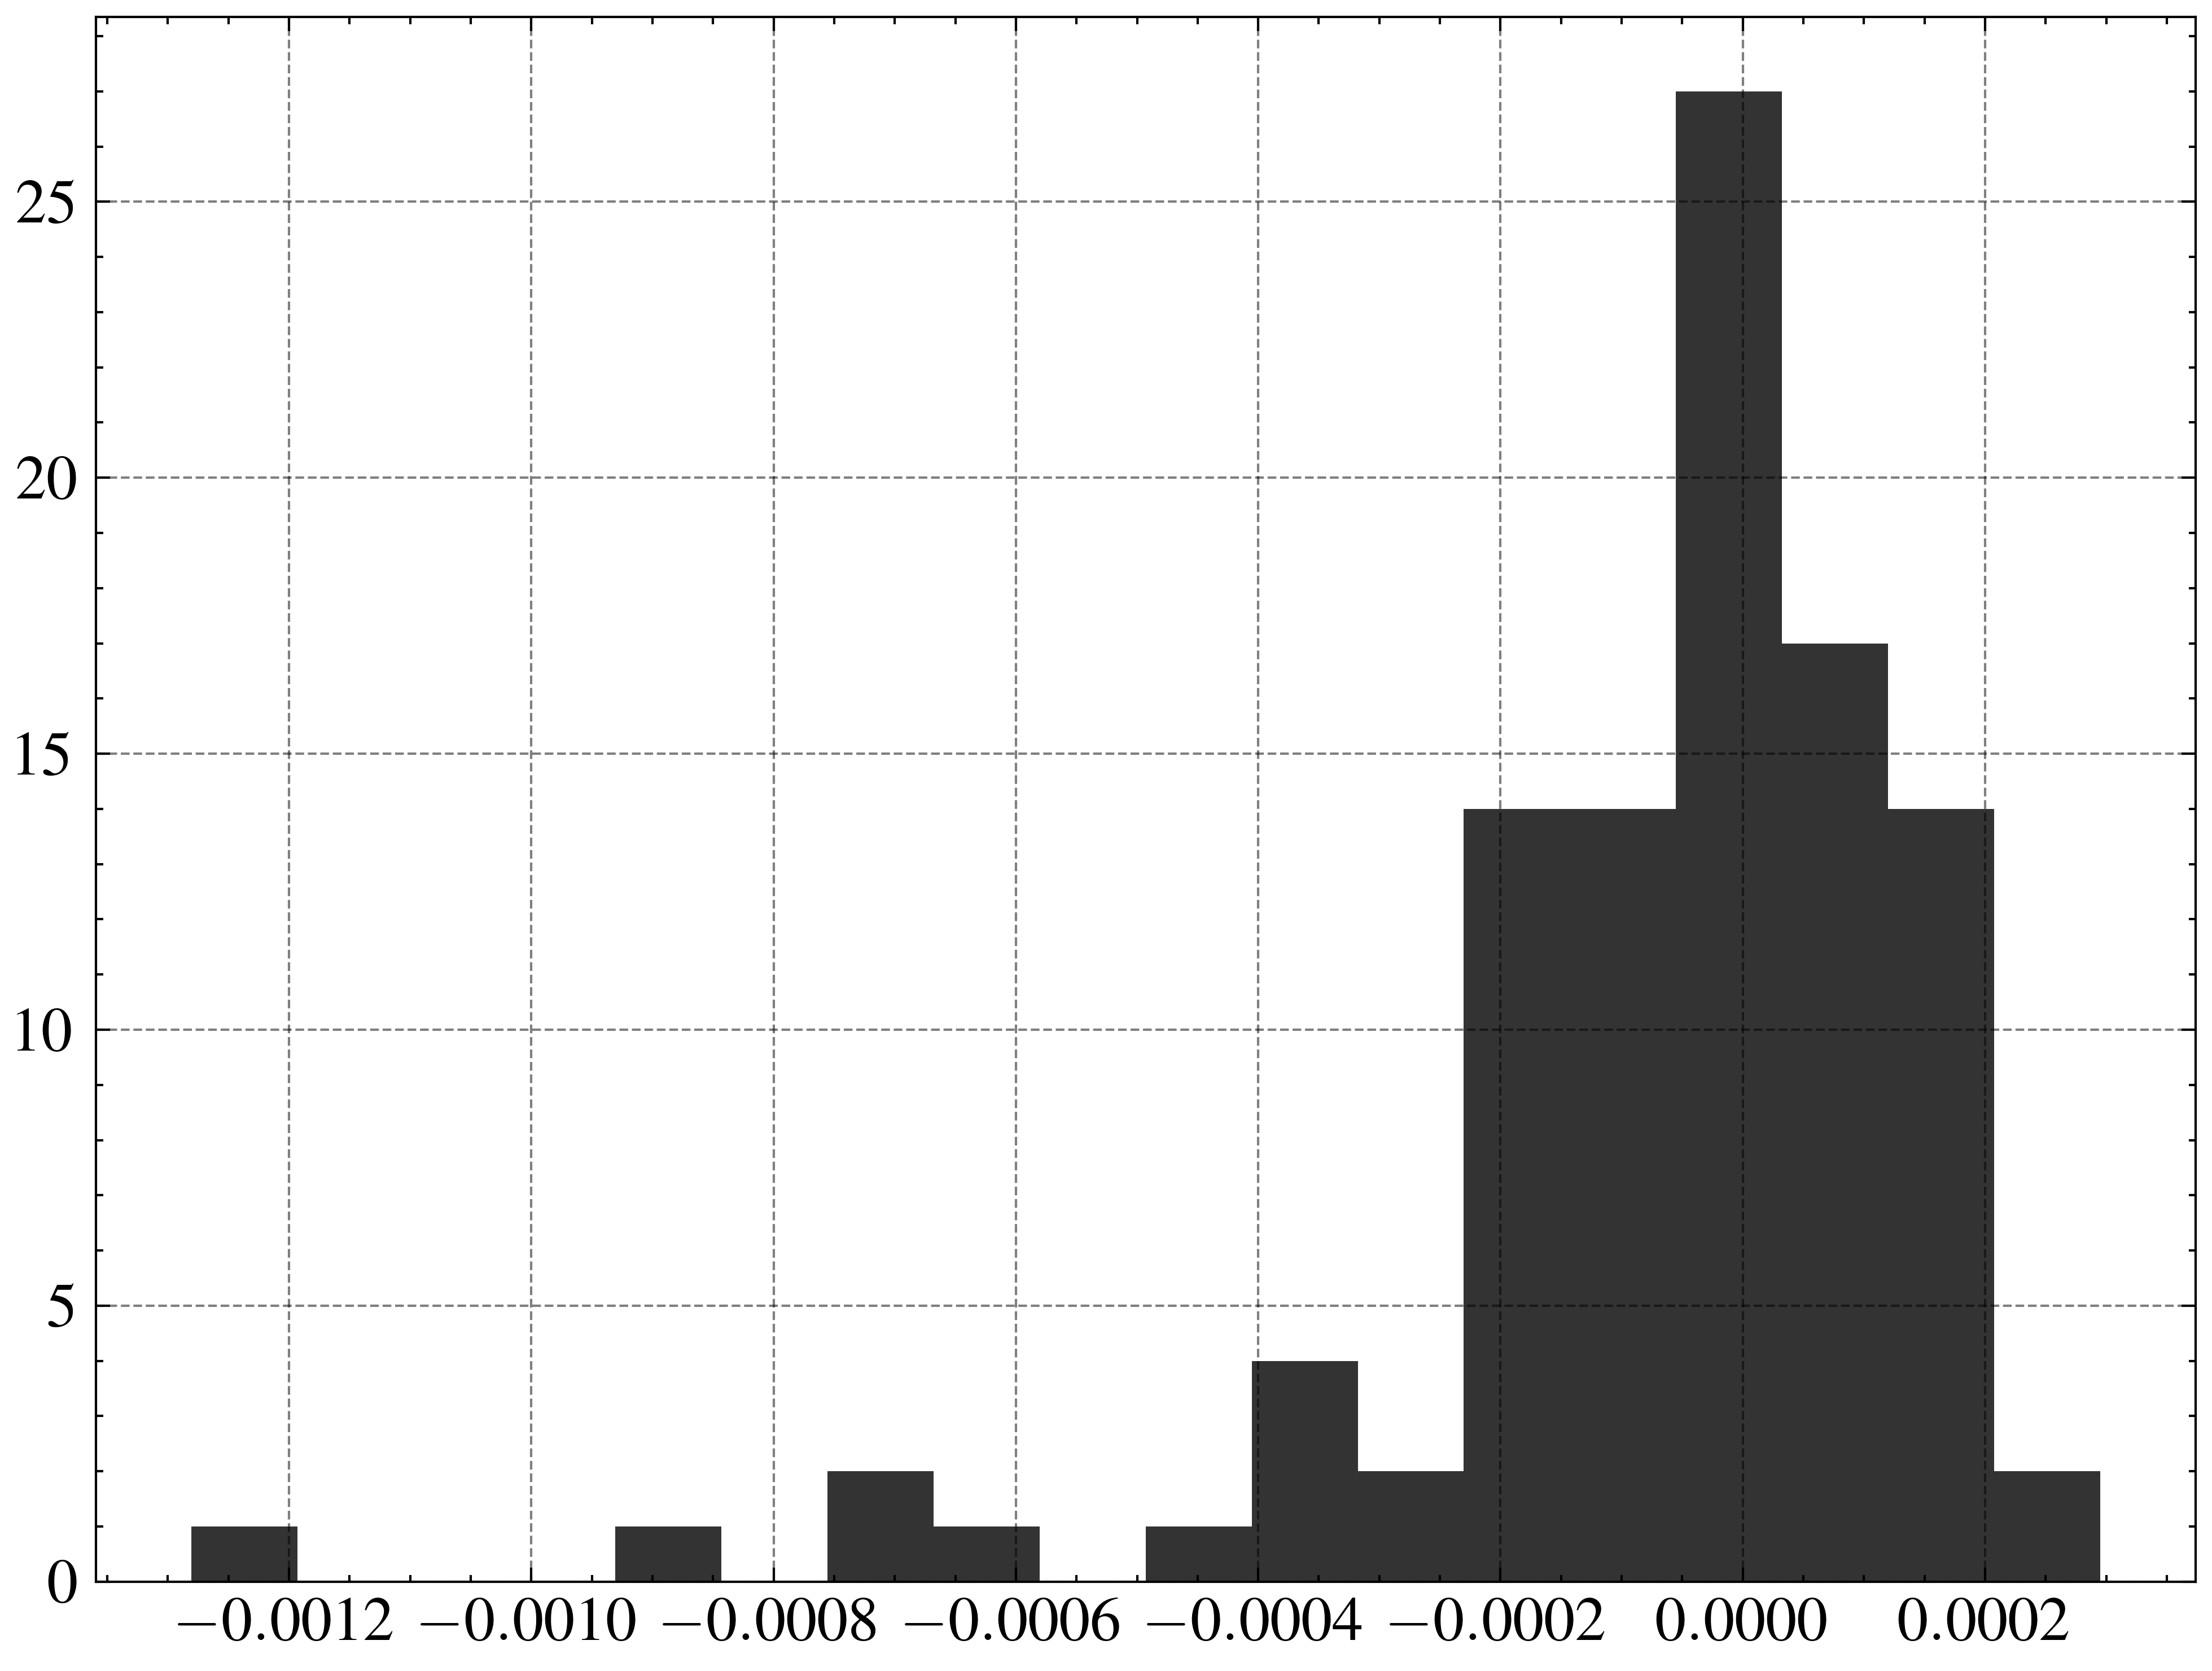

In [7]:
plt.figure(figsize=(8, 6))
counts, bins, _ = plt.hist(
    np.array(B_arr),
    bins='auto',           # либо, например, bins=40
    linewidth=1.0,
    alpha=0.8,
    label=r'${B}_{\tau\tau}$ toys'
)


In [8]:
EPS

{'lep': 3.828e-05,
 'pipi': 1.1946402942254255e-05,
 'rhorho': 5.9508519297293916e-06,
 'pirho': 1.5257199321901686e-05,
 'pilep': 4.930549229668e-05,
 'rholep': 4.107062528262462e-05}

In [9]:
np.mean(B_arr)

np.float64(-6.652076235597382e-05)

In [10]:
sum(list([EPS[_] for _ in EPS]))

0.00016181057177318996